In [4]:
import os
import warnings

from db_queries import get_location_metadata
import pandas as pd

from covid_model_deaths import runner
from covid_model_deaths.deaths_io import InputsContext, MEASURES, Checkpoint
from covid_model_deaths.globals import COLUMNS

pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
warnings.simplefilter('ignore')

RUN_TYPE = 'prod'
DATA_VERSION = '2020_05_01.08'
DATESTAMP_LABEL = '2020_05_01_Europe_newmod'

PEAK_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_20/peak_locs_april20_.csv'
PEAK_DURATION_FILE = None
R0_FILE = None
LOCATION_SET_VERSION = 655
r0_locs = []

CODE_DIR = os.path.abspath('../src/covid_model_deaths')
OUTPUT_DIR = f'/ihme/covid-19/deaths/{RUN_TYPE}/{DATESTAMP_LABEL}'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
inputs = InputsContext(f'/ihme/covid-19/model-inputs/{DATA_VERSION}')
checkpoint = Checkpoint(OUTPUT_DIR)

print(f'Writing to {OUTPUT_DIR}')
print(CODE_DIR)
print(checkpoint)

raw_draw_path = f'{OUTPUT_DIR}/euro_data.csv'
average_draw_path = f'{OUTPUT_DIR}/past_avg_euro_data.csv'
yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_29_Europe/euro_data.csv'
before_yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_28_Europe/euro_data.csv'


def filter_data(data: pd.DataFrame, kind='full') -> pd.DataFrame:
    # manually adjust Iceland spike (0 deaths to 5 deaths to 0 deaths in March...)
    iceland = data['Country/Region'] == 'Iceland'
    iceland_spike = iceland & (data['Date'] == pd.Timestamp('2020-03-15'))
    if kind == 'full':
        data.loc[iceland_spike, ['Deaths', 'Death rate']] = 0
    elif kind == 'deaths':
        data = data.loc[~iceland_spike]
        min_iceland_date = data.loc[iceland, 'Date'].min()
        data.loc[iceland, 'Days'] = (data.loc[iceland, 'Date'] - min_iceland_date).dt.days
        
    # dropping data from May 1 for Mississippi for Lazio and Mississippi
    mississippi_lazio = data['location_id'].isin([547, 35506])
    mississippi_lazio_spike = mississippi_lazio & (data['Date'] == pd.Timestamp('2020-05-01'))
    data = data.loc[~mississippi_lazio_spike].reset_index(drop=True)
        
    return data

def get_locations(location_set_version_id):
    # get locaton_ids
    loc_df = get_location_metadata(location_set_id=111,
                                   location_set_version_id=location_set_version_id)

    # Drop any locations in the US and keep only most detailed for modeling
    most_detailed = loc_df['most_detailed'] == 1
    non_us = ~loc_df['path_to_top_parent'].str.startswith('102,')
    # Bad aggregates that made it in the hierarchy
    good_ids = ~loc_df['location_id'].isin([53474, 53451, 53452]) 
    keep_columns = ['location_id', 'location_ascii_name', 'parent_id', 'level', 'most_detailed']

    euro_df = loc_df.loc[most_detailed & non_us & good_ids, keep_columns]
    euro_df = euro_df.rename(columns={'location_ascii_name':'Location'})

    # Add parents
    loc_df = loc_df[['location_id', 'location_ascii_name']]
    loc_df = loc_df.rename(columns={'location_id':'parent_id',
                                    'location_ascii_name':'Country/Region'})
    euro_df = euro_df.merge(loc_df)

    euro_df = euro_df.loc[:, ['location_id', 'Location', 'Country/Region', 'level']]
    return euro_df




2020-05-03 14:14:23.879 | DEBUG    | covid_model_deaths.deaths_io.checkpoint:_setup_checkpoint_dir:45 - Making checkpoint directory at /ihme/covid-19/deaths/prod/2020_05_01_Europe_newmod/checkpoint


Writing to /ihme/covid-19/deaths/prod/2020_05_01_Europe_newmod
/ihme/code/rmbarber/covid-model-deaths/src/covid_model_deaths
Checkpoint(/ihme/covid-19/deaths/prod/2020_05_01_Europe_newmod/checkpoint)


In [ ]:
loc_df = get_locations(LOCATION_SET_VERSION)
input_full_df = filter_data(inputs.load(MEASURES.full_data))
input_death_df = filter_data(inputs.load(MEASURES.deaths), kind='deaths')
input_age_pop_df = inputs.load(MEASURES.age_pop)
input_age_death_df = inputs.load(MEASURES.age_death)

# Save pops for Bobby.
pop_df = input_age_pop_df.merge(loc_df).reset_index(drop=True)
pop_df[['location_id', 'Location', 'age_group', 'population']].to_csv(f'{OUTPUT_DIR}/pops.csv', index=False)

checkpoint.write('location', loc_df)
checkpoint.write('full_data', input_full_df)
checkpoint.write('deaths', input_death_df)
checkpoint.write('age_pop', input_age_pop_df)
checkpoint.write('age_death', input_age_death_df)

## prepare data for case-to-death

In [ ]:
%%time
full_df = checkpoint.load('full_data')
death_df = checkpoint.load('deaths')
age_pop_df = checkpoint.load('age_pop')
age_death_df = checkpoint.load('age_death')

backcast_location_ids = runner.get_backcast_location_ids(full_df, most_detailed=False)
cases_and_backcast_deaths_df = runner.make_cases_and_backcast_deaths(full_df, death_df, age_pop_df, age_death_df, backcast_location_ids, subnat=False)

cases_and_backcast_deaths_df.to_csv(f'{OUTPUT_DIR}/backcast_for_case_to_death.csv', index=False)
checkpoint.write('cases_and_backcast_deaths', cases_and_backcast_deaths_df)


## Impute death thresholds.

In [ ]:
%%time
cases_and_backcast_deaths_df = checkpoint.load('cases_and_backcast_deaths')
loc_df = checkpoint.load('location')
threshold_dates = runner.impute_death_threshold(cases_and_backcast_deaths_df,
                                                loc_df)
threshold_dates.to_csv(f'{OUTPUT_DIR}/threshold_dates.csv', index=False)
checkpoint.write('threshold_dates', threshold_dates)

## Make last day data

In [ ]:
full_df = checkpoint.load('full_data')
threshold_dates = checkpoint.load('threshold_dates')

date_mean_df = runner.make_date_mean_df(threshold_dates)
last_day_df = runner.make_last_day_df(full_df,date_mean_df)
last_day_df.to_csv(f'{OUTPUT_DIR}/last_day.csv', index=False)

checkpoint.write('date_mean', date_mean_df)
checkpoint.write('last_day', last_day_df)

## get leading indicator

In [ ]:
full_df = checkpoint.load('full_data')
loc_df = checkpoint.load('location')

dcr_df, dhr_df, leading_indicator_df = runner.make_leading_indicator(
    full_df.loc[full_df[COLUMNS.location_id].isin(loc_df[COLUMNS.location_id].to_list())]
)
dcr_df.to_csv(f'{OUTPUT_DIR}/lagged_death_to_case_ratios.csv', index=False)
dhr_df.to_csv(f'{OUTPUT_DIR}/lagged_death_to_hosp_ratios.csv', index=False)
leading_indicator_df.to_csv(f'{OUTPUT_DIR}/leading_indicator.csv', index=False)
leading_indicator_df = leading_indicator_df[[COLUMNS.location_id, COLUMNS.date, COLUMNS.ln_age_death_rate]]
leading_indicator_df = leading_indicator_df.loc[~leading_indicator_df[COLUMNS.ln_age_death_rate].isnull()]

checkpoint.write('leading_indicator', leading_indicator_df)

## store model data and covariate data, submit models

In [ ]:
full_df = checkpoint.load('full_data')
death_df = checkpoint.load('deaths')
age_pop_df = checkpoint.load('age_pop')
age_death_df = checkpoint.load('age_death')
date_mean_df = checkpoint.load('date_mean')
last_day_df = checkpoint.load('last_day')
leading_indicator_df = checkpoint.load('leading_indicator')
loc_df = checkpoint.load('location')

submodel_dict = runner.submit_models(full_df, death_df, age_pop_df, age_death_df, date_mean_df, leading_indicator_df,
                                     loc_df, r0_locs,
                                     PEAK_FILE, OUTPUT_DIR, 'best',  # DATA_VERSION, 
                                     R0_FILE, CODE_DIR, verbose=False)

checkpoint.write('submodel_dict', submodel_dict)

## compile draws


In [ ]:
full_df = checkpoint.load('full_data')
age_pop_df = checkpoint.load('age_pop')
threshold_dates = checkpoint.load('threshold_dates')
submodel_dict = checkpoint.load('submodel_dict')
loc_df = checkpoint.load('location')

obs_df = full_df[full_df.location_id.isin(loc_df.location_id)]

draw_dfs, past_draw_dfs, models_used, days, ensemble_draws_dfs = runner.compile_draws(loc_df,
                                                                                      submodel_dict,
                                                                                      obs_df,
                                                                                      threshold_dates,
                                                                                      age_pop_df)

if 'location' not in models_used:
    raise ValueError('No location-specific draws used, must be using wrong tag')
draw_df = pd.concat(draw_dfs)
model_type_df = pd.DataFrame({'location': loc_df['Location'].unique().tolist(),
                              'model_used': models_used})

# write
draw_df.to_csv(f'{OUTPUT_DIR}/euro_data.csv', index=False)
model_type_df.to_csv(f'{OUTPUT_DIR}/models_used.csv', index=False)
ensemble_plot_path = runner.make_and_save_draw_plots(OUTPUT_DIR, loc_df,
                                                     ensemble_draws_dfs, days, models_used, age_pop_df)
print(ensemble_plot_path)
checkpoint.write('draw_data', draw_df)


## combine with previous predictions

In [ ]:
avg_df = runner.average_draws(raw_draw_path, yesterday_draw_path, before_yesterday_draw_path)
avg_df.to_csv(average_draw_path, index=False)
compare_average_plot_path = runner.make_and_save_compare_average_plots(OUTPUT_DIR,
                                                                       raw_draw_path,
                                                                       average_draw_path,
                                                                       yesterday_draw_path,
                                                                       before_yesterday_draw_path,
                                                                       'Not United States of America')

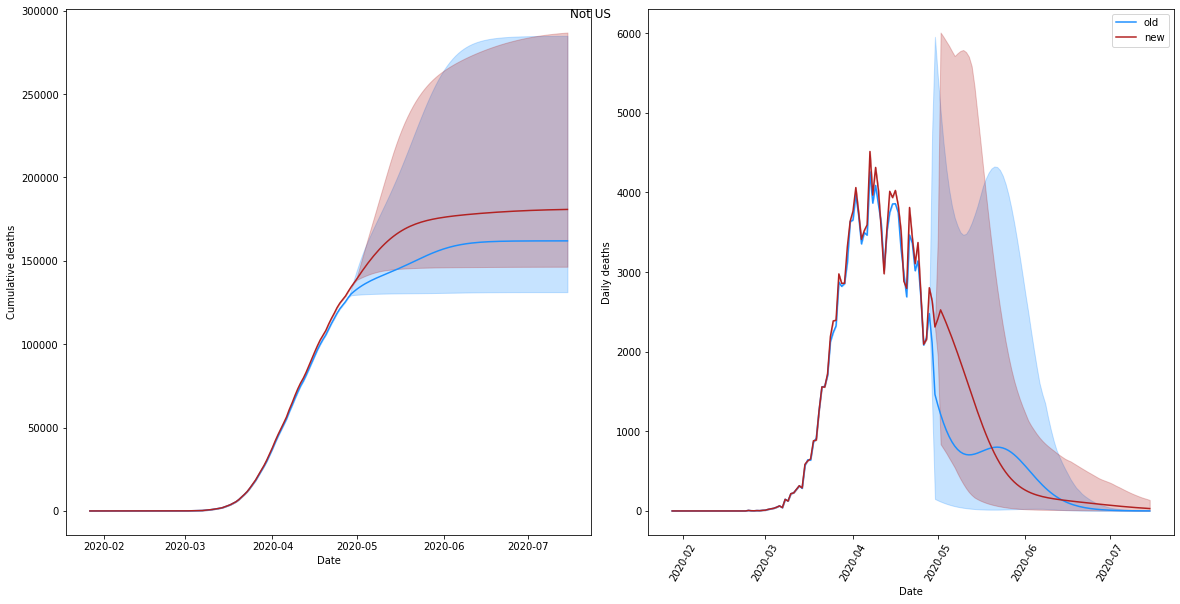

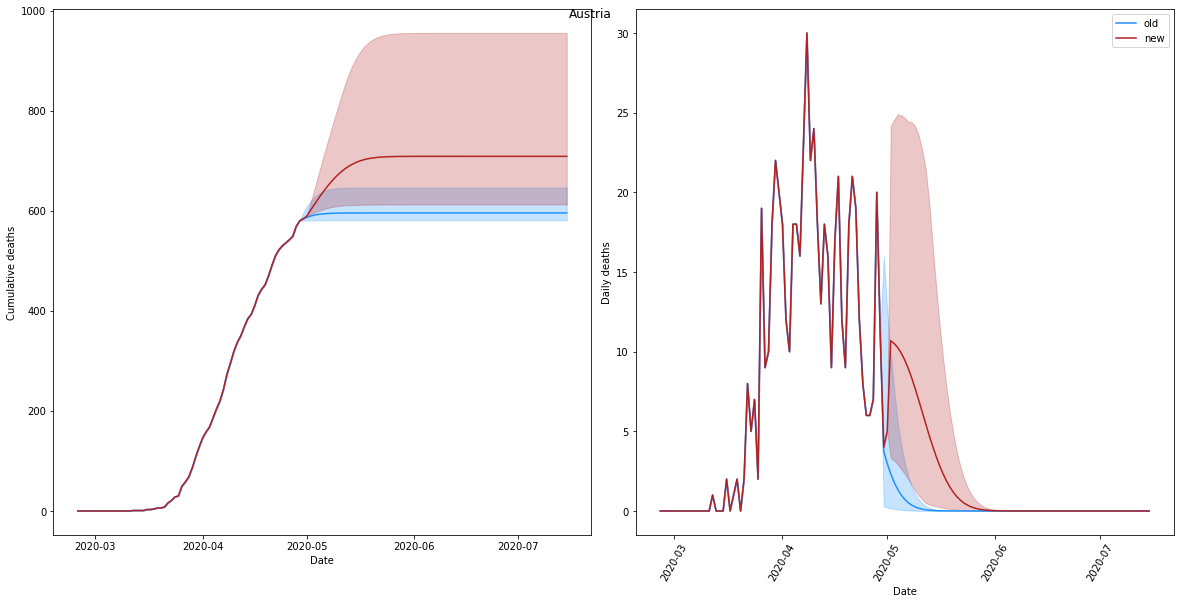

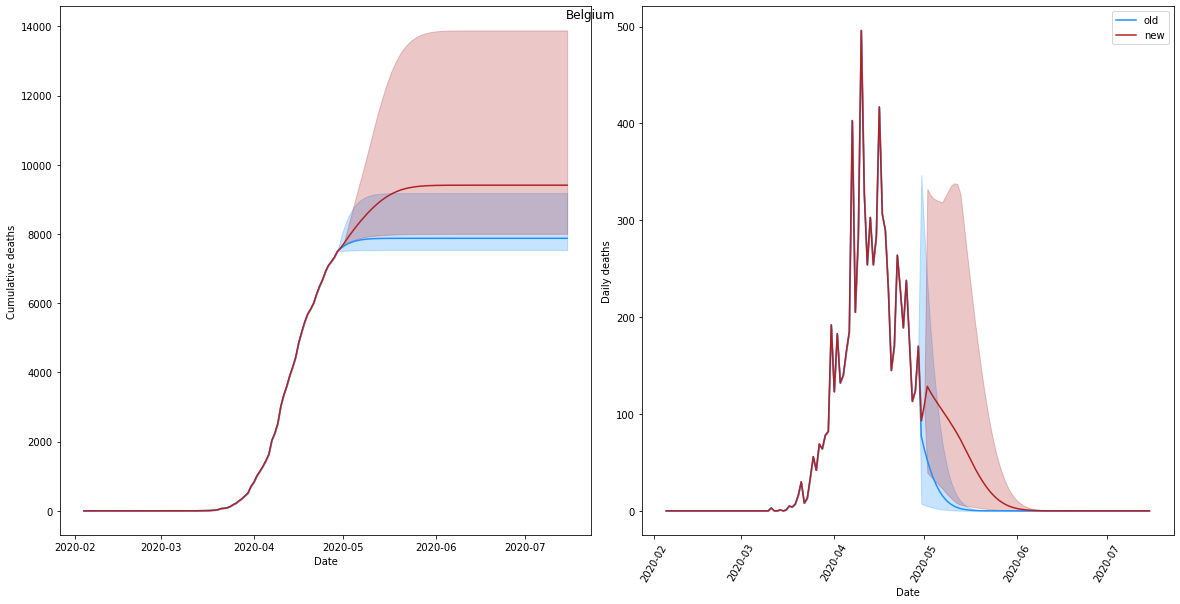

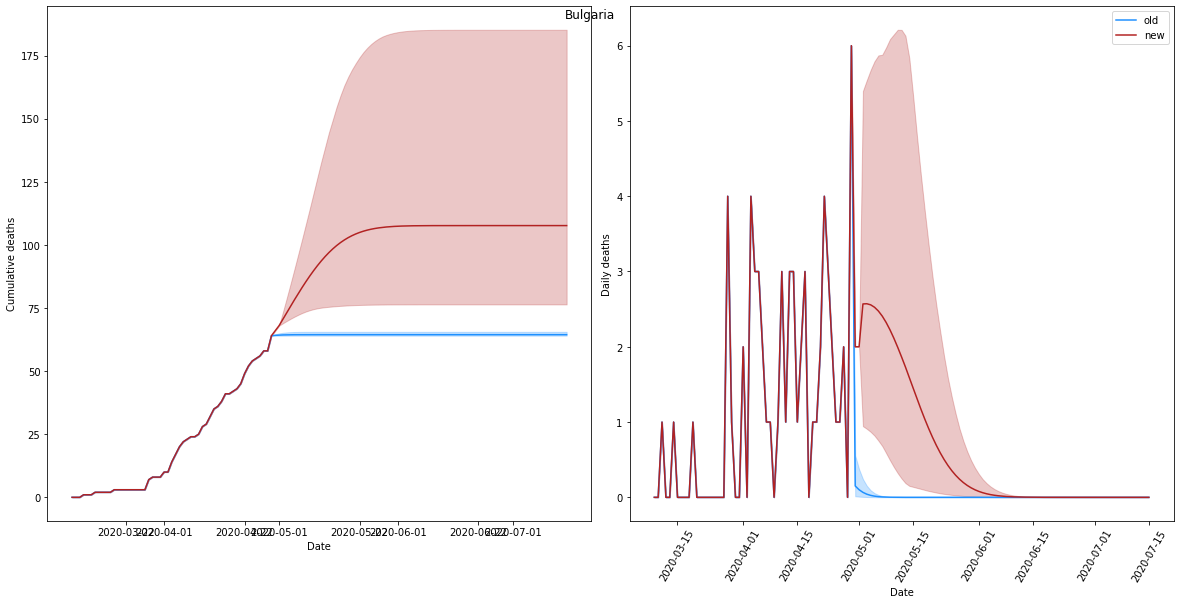

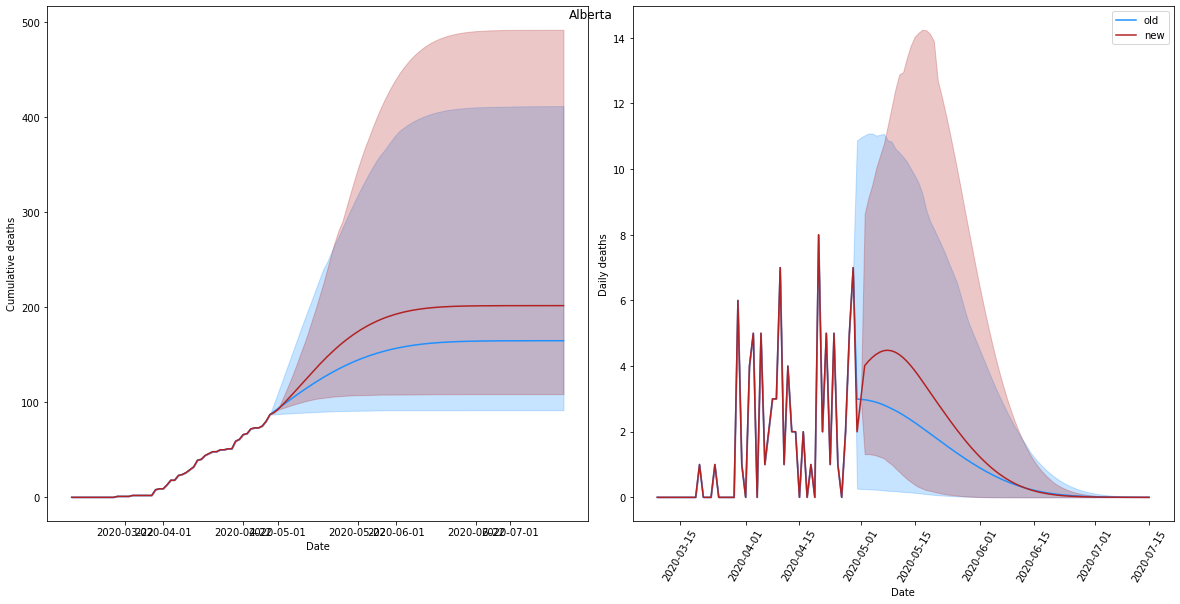

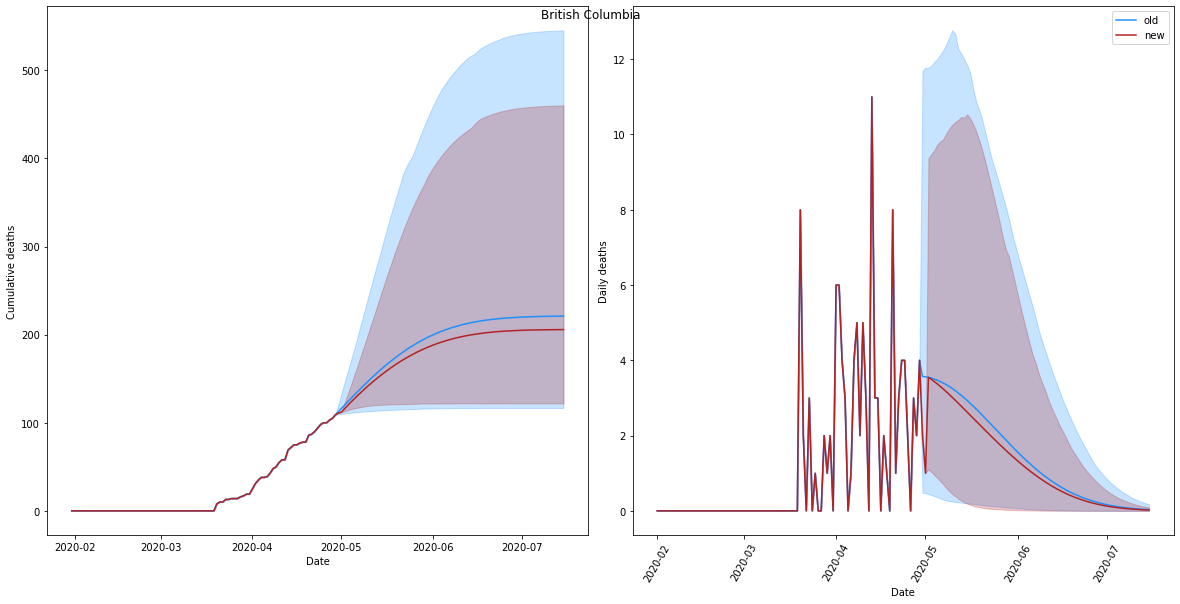

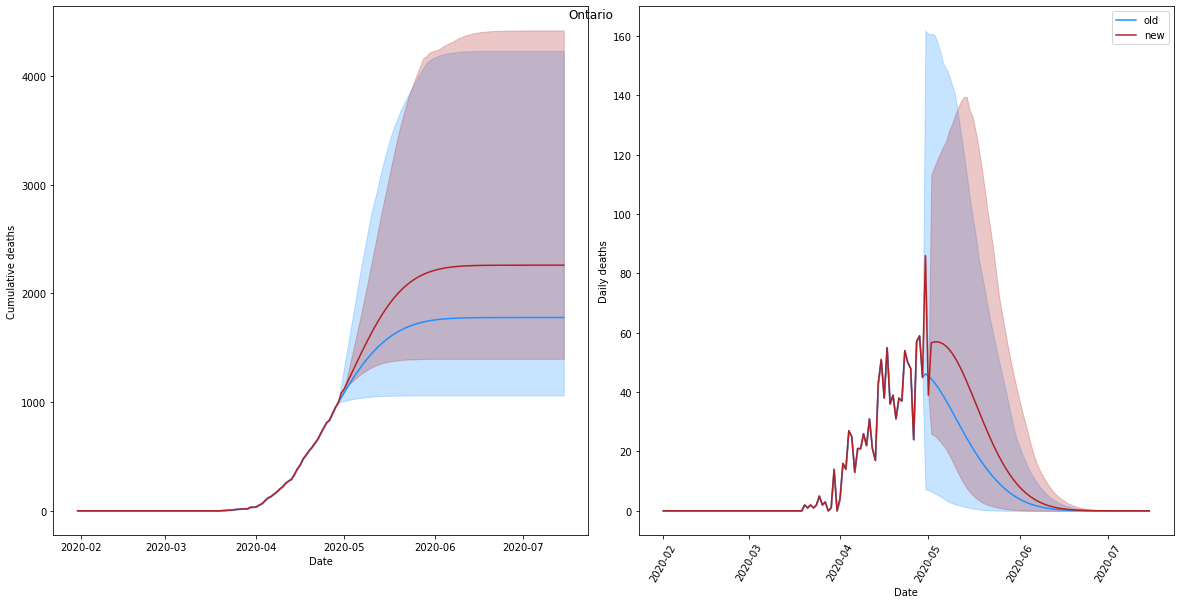

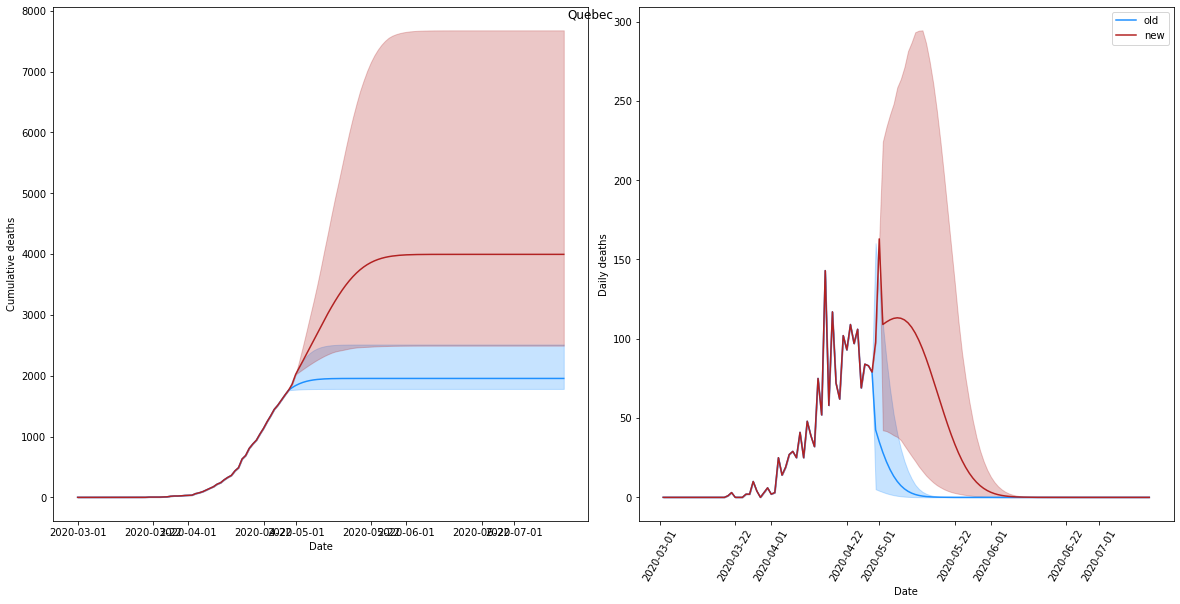

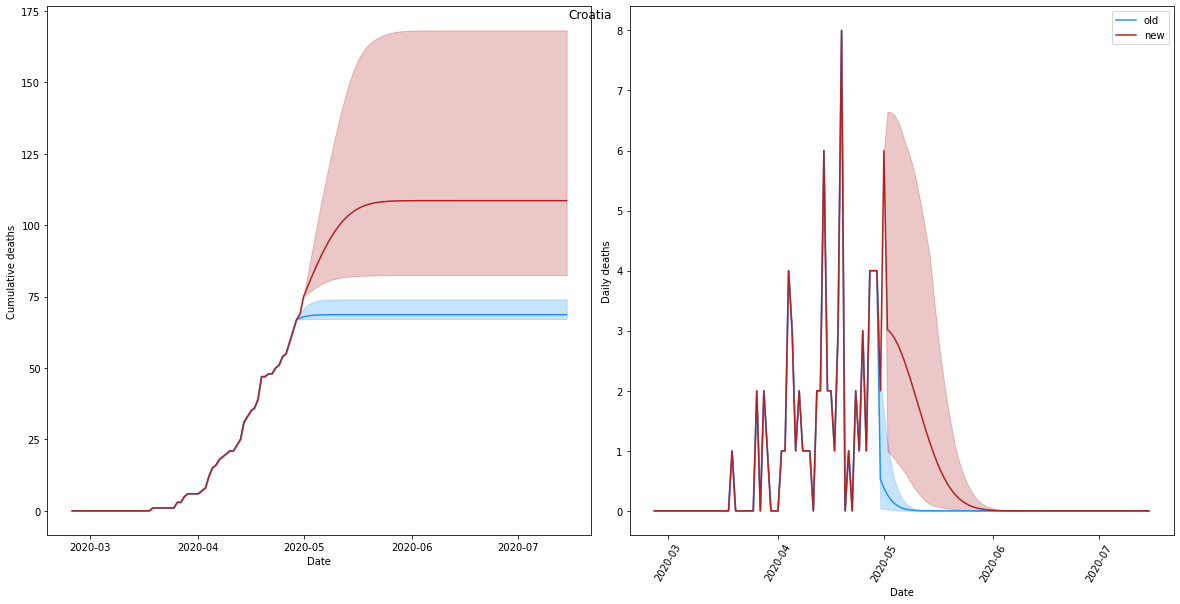

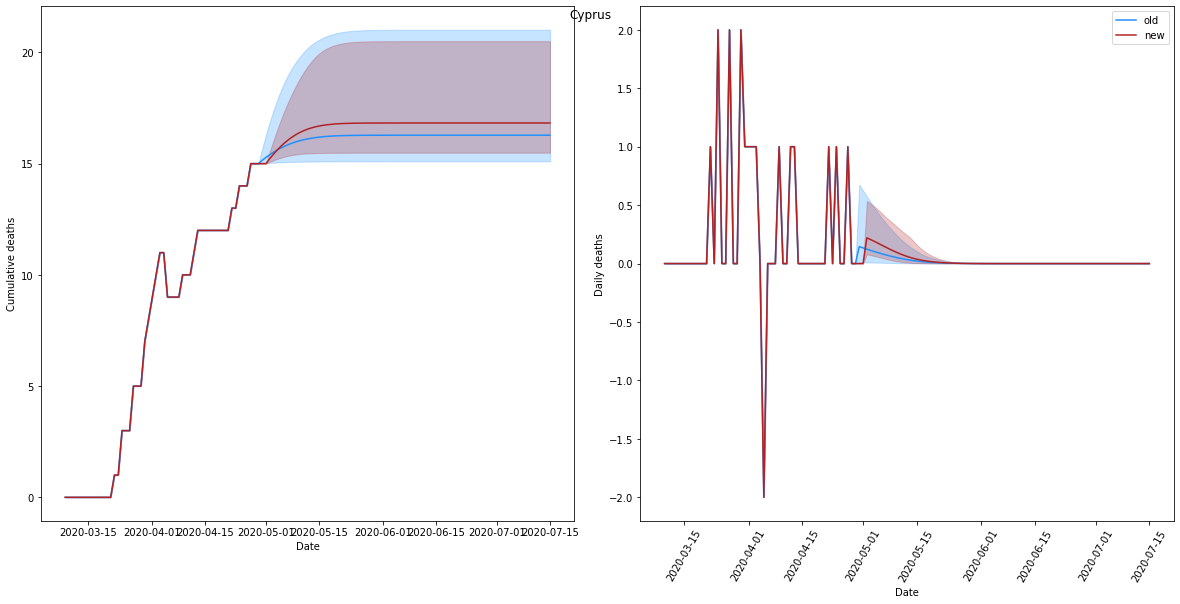

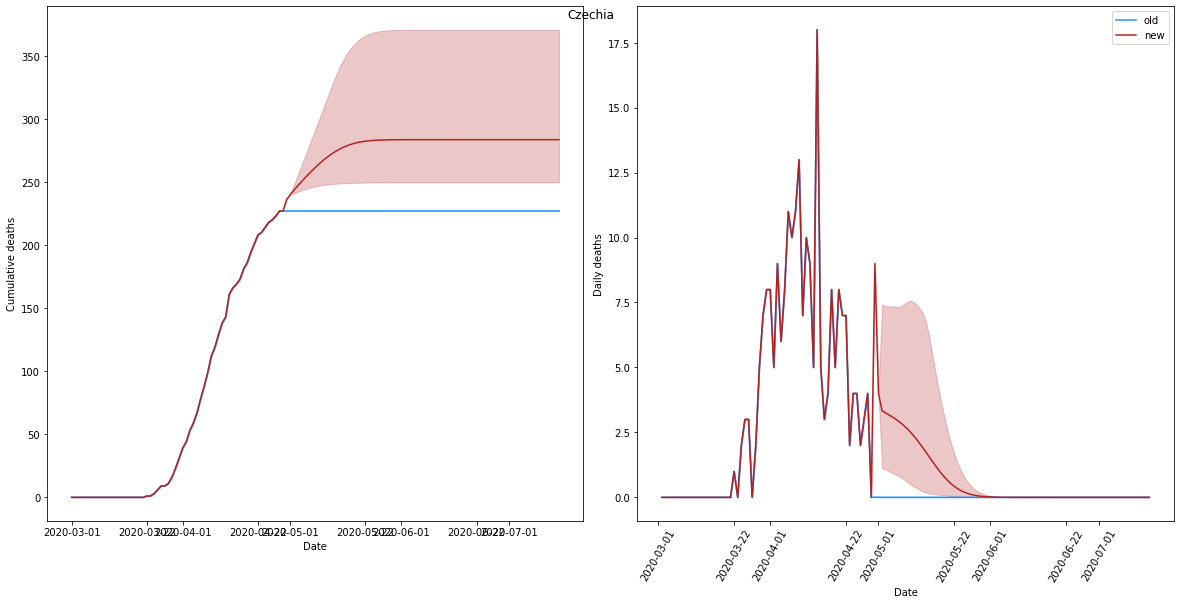

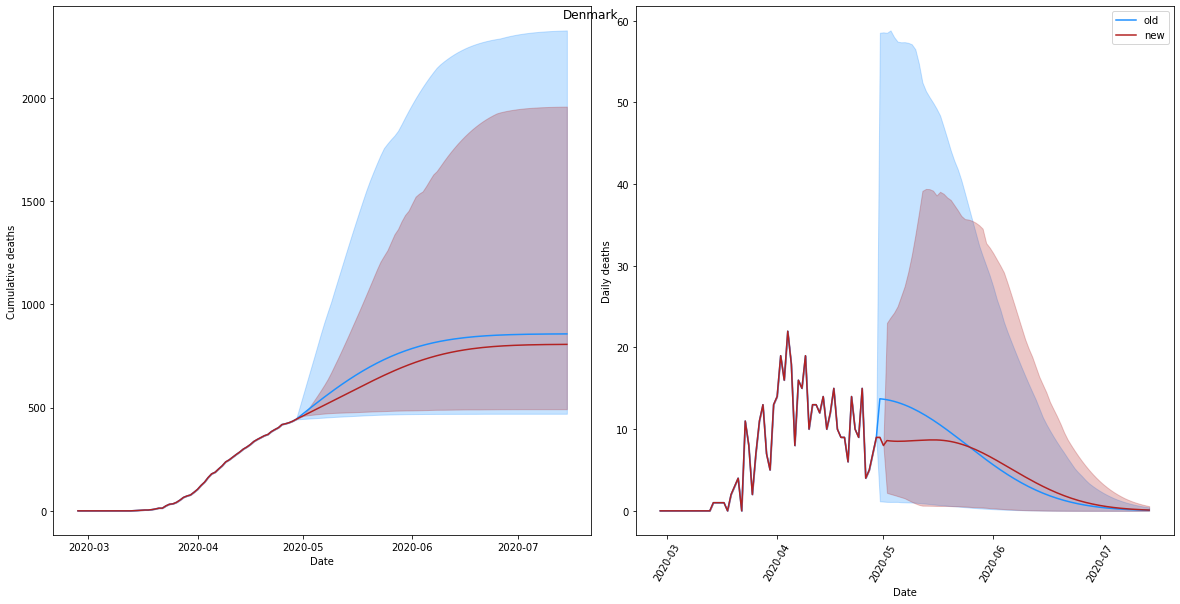

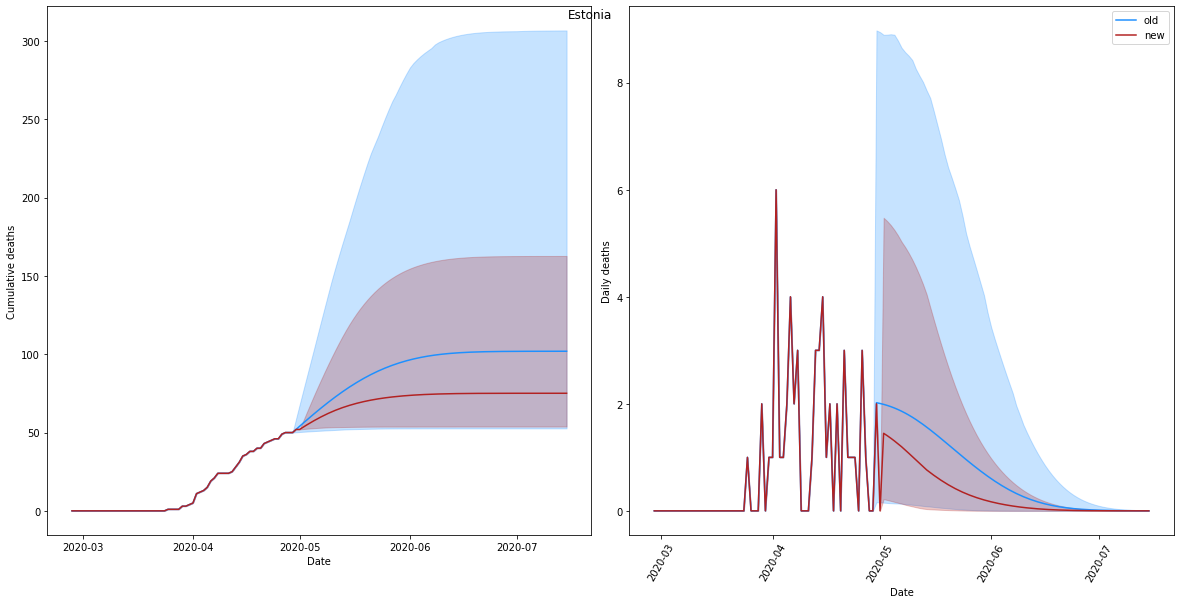

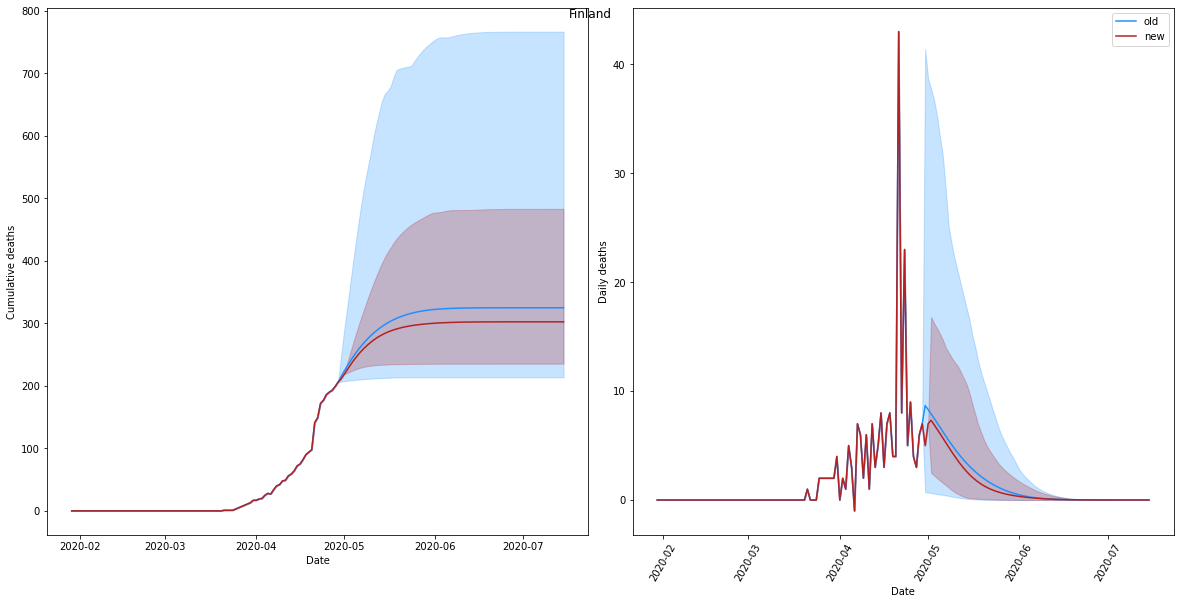

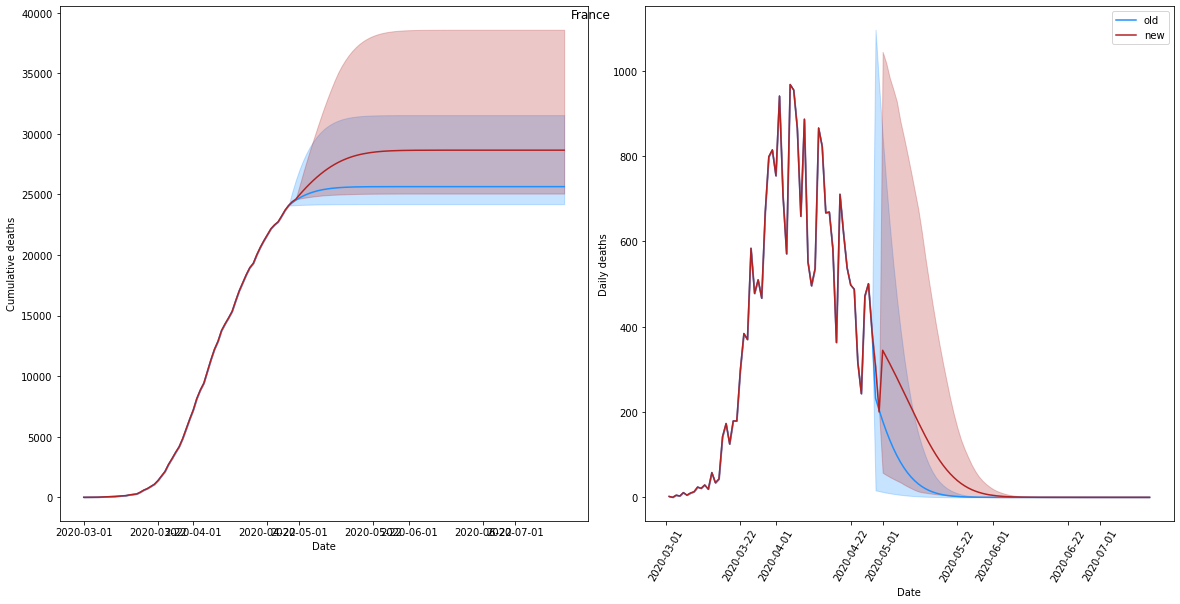

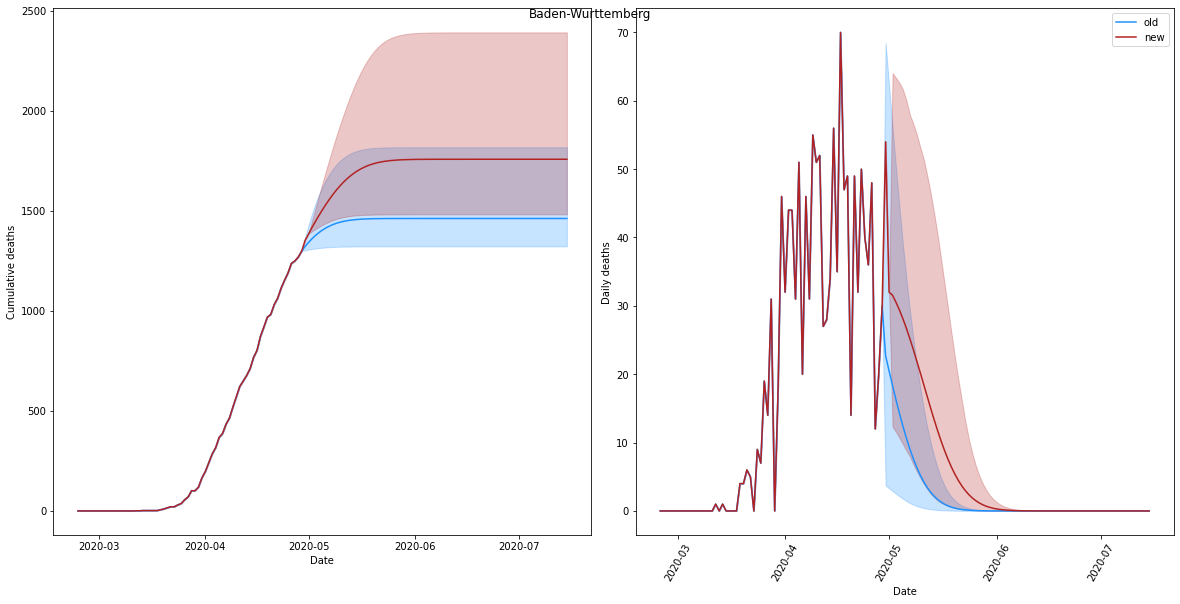

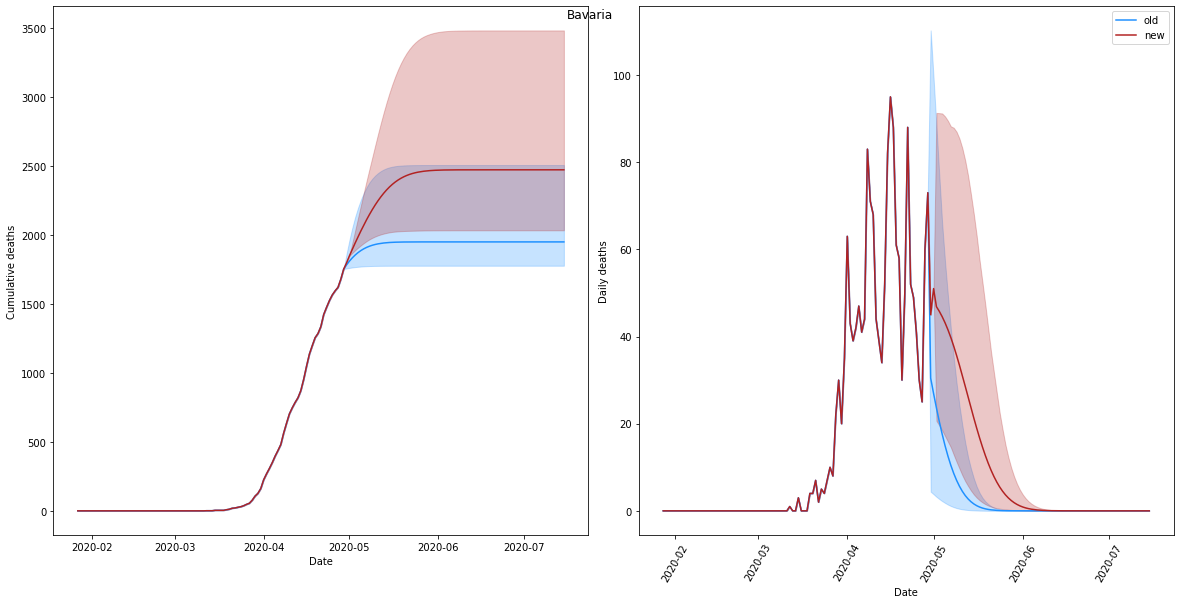

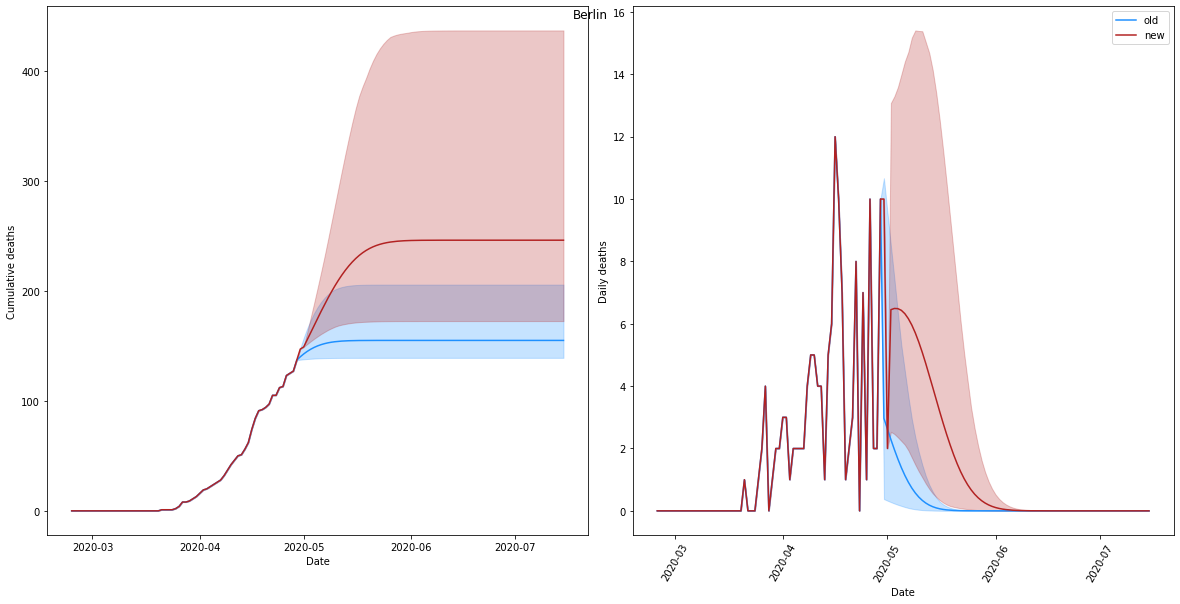

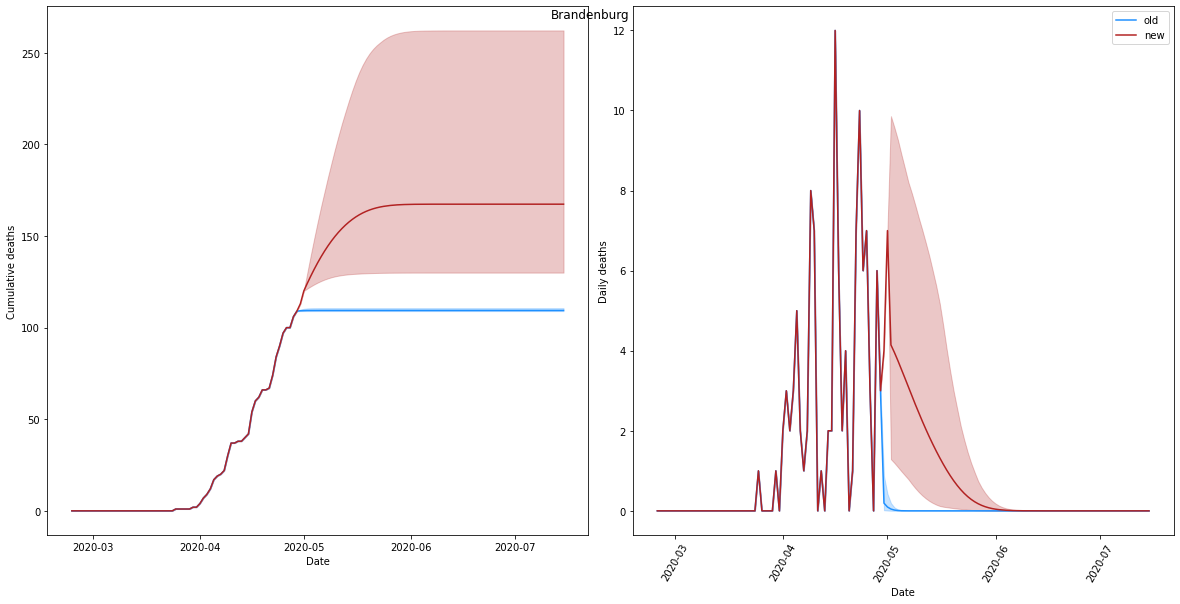

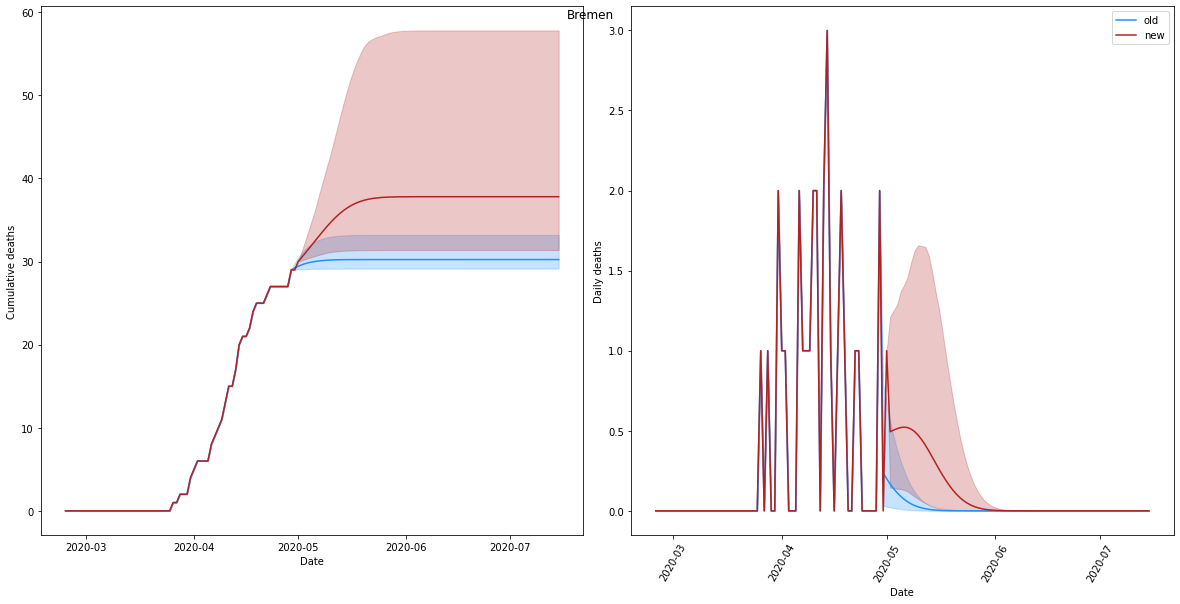

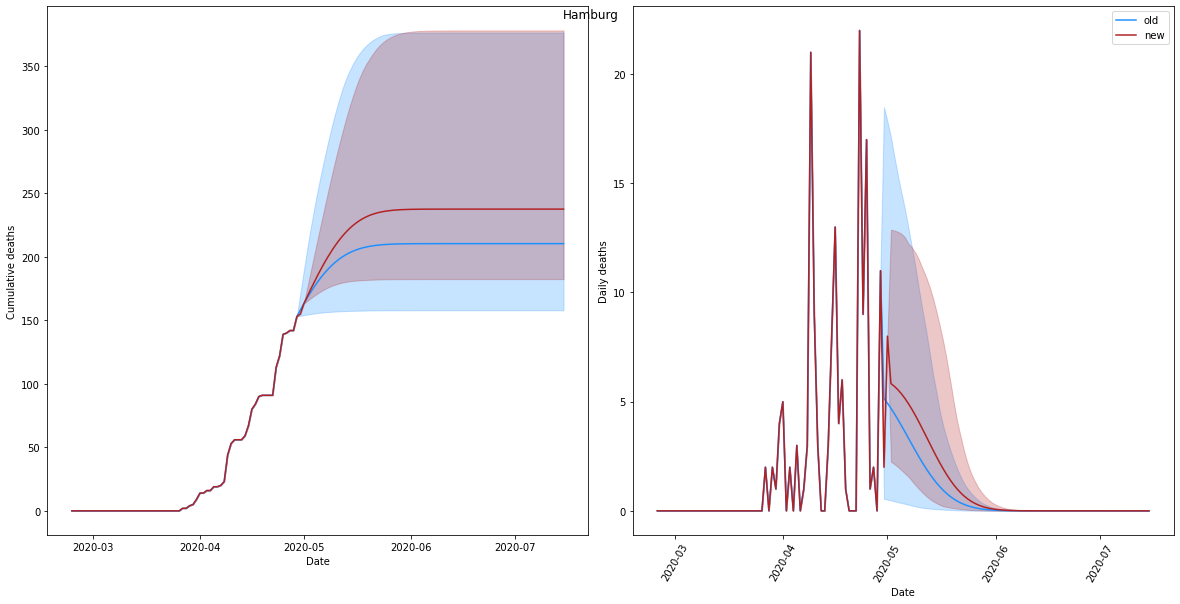

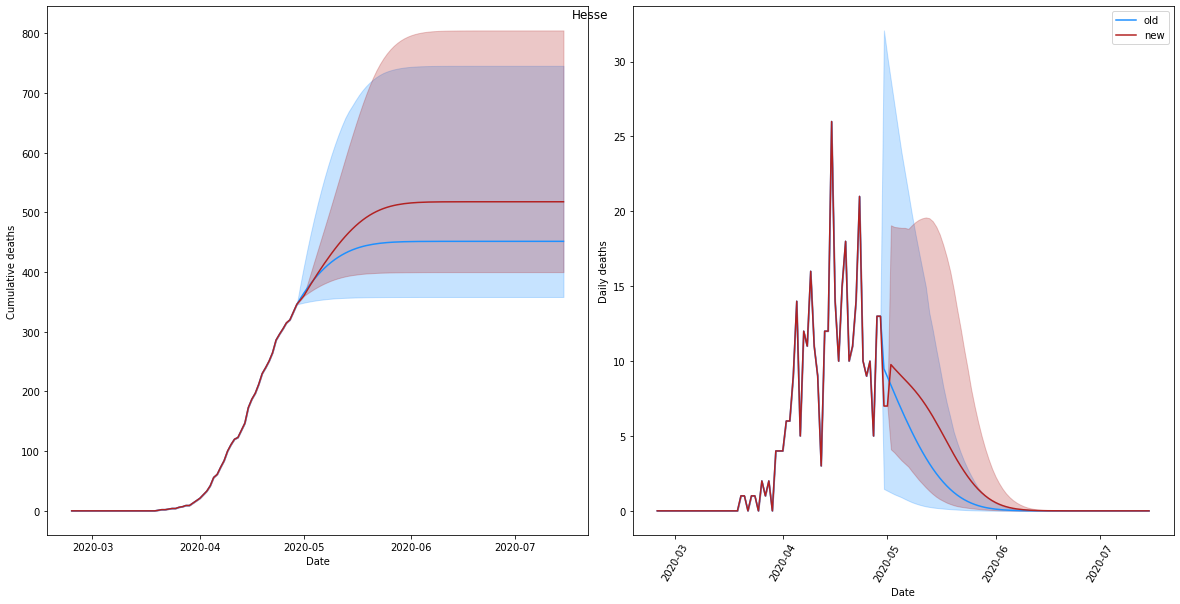

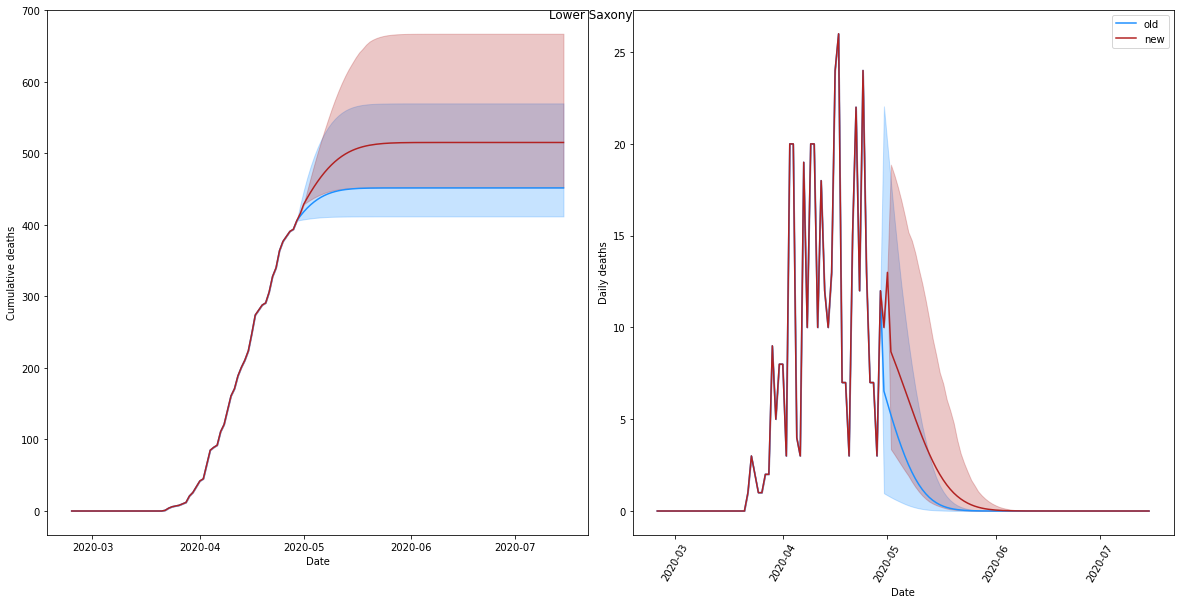

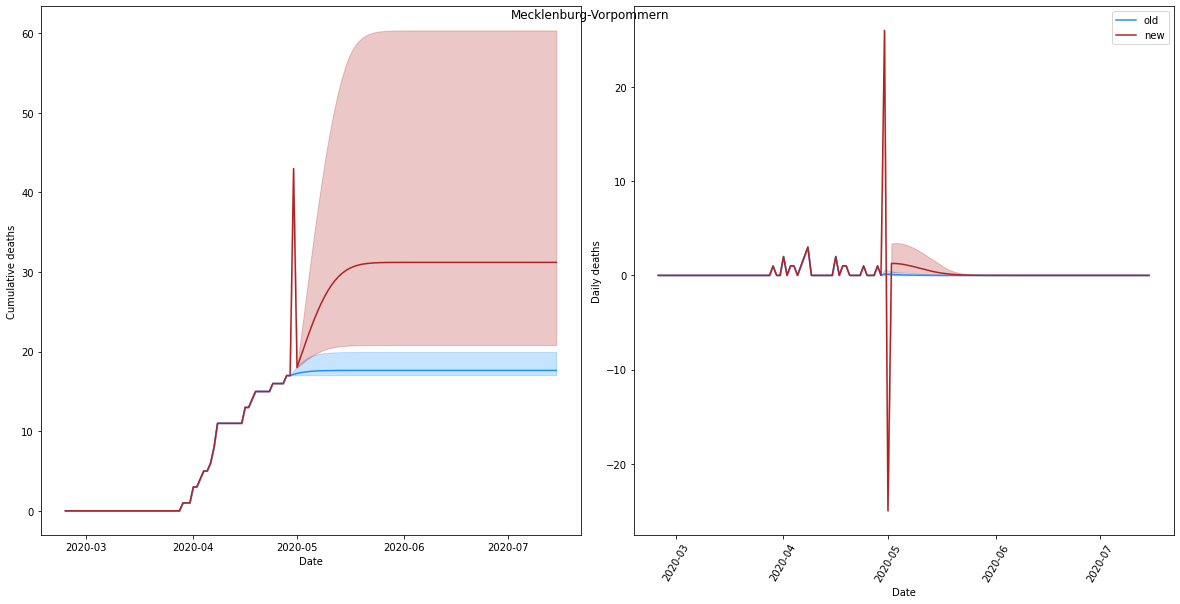

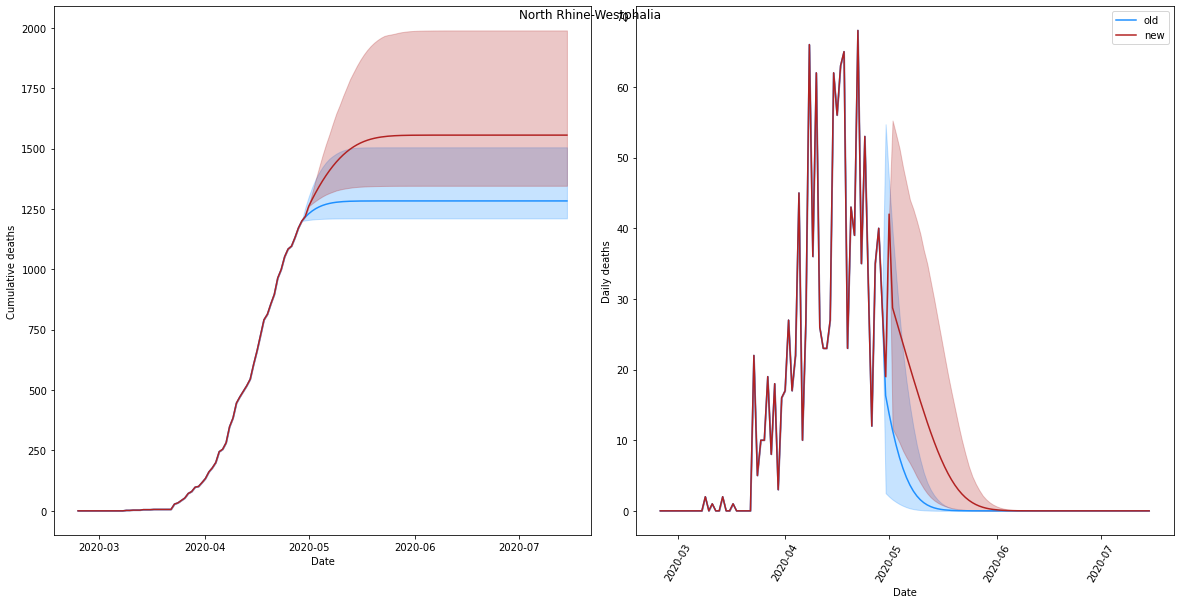

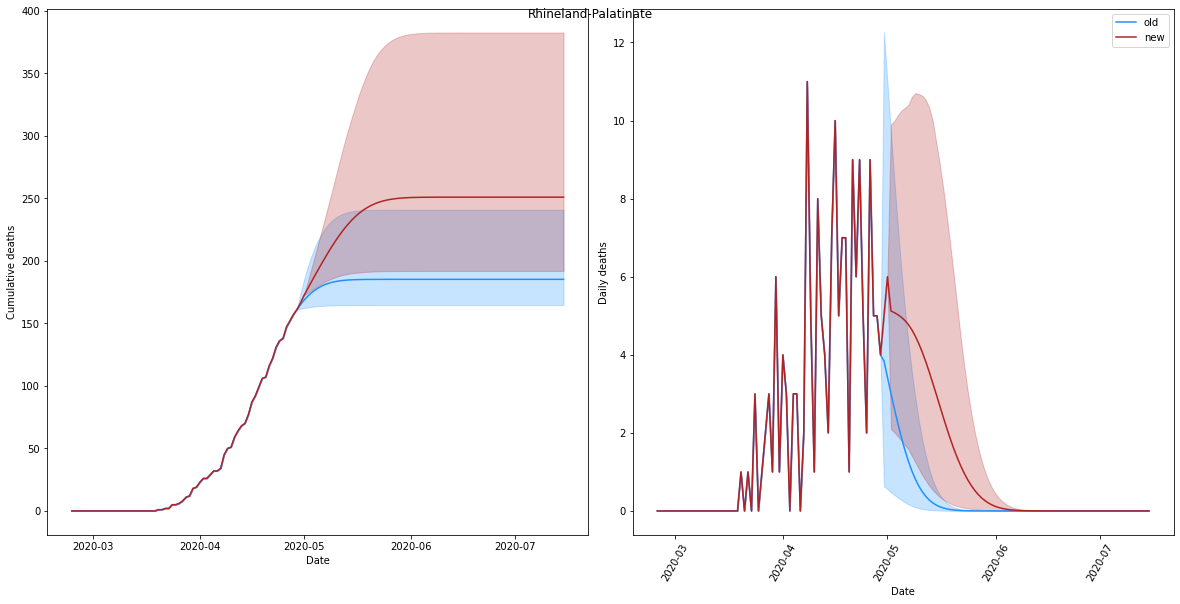

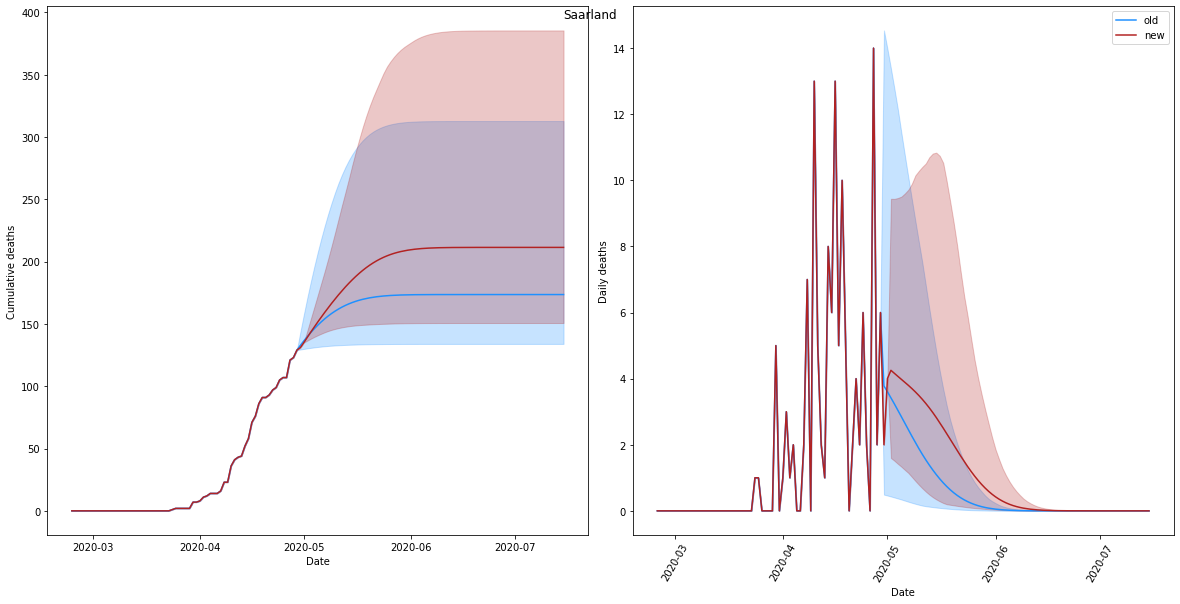

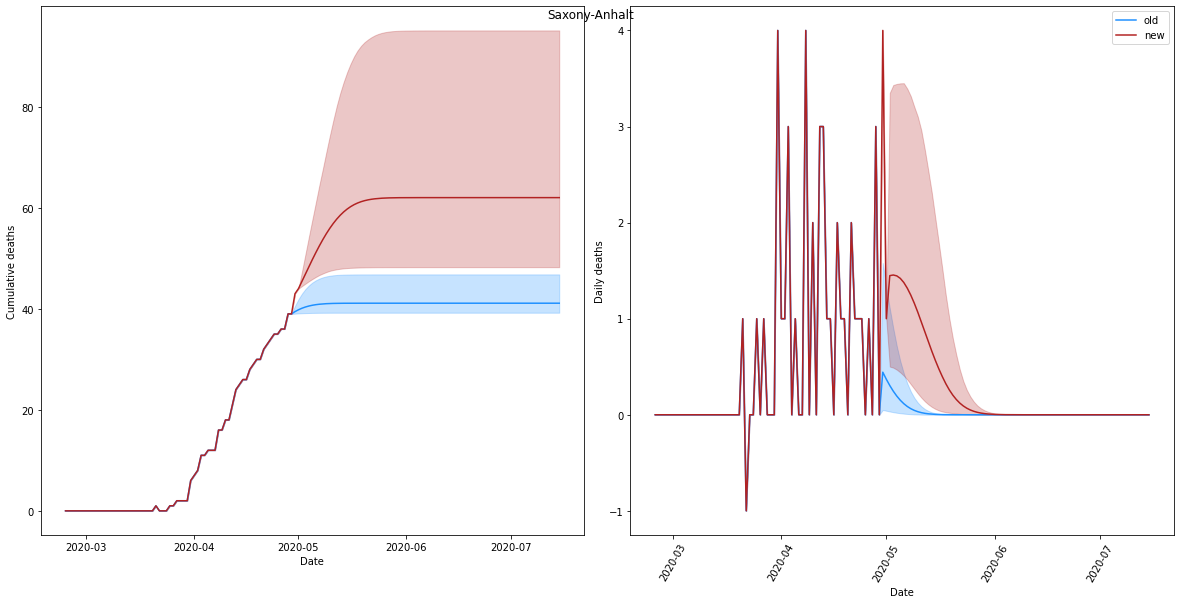

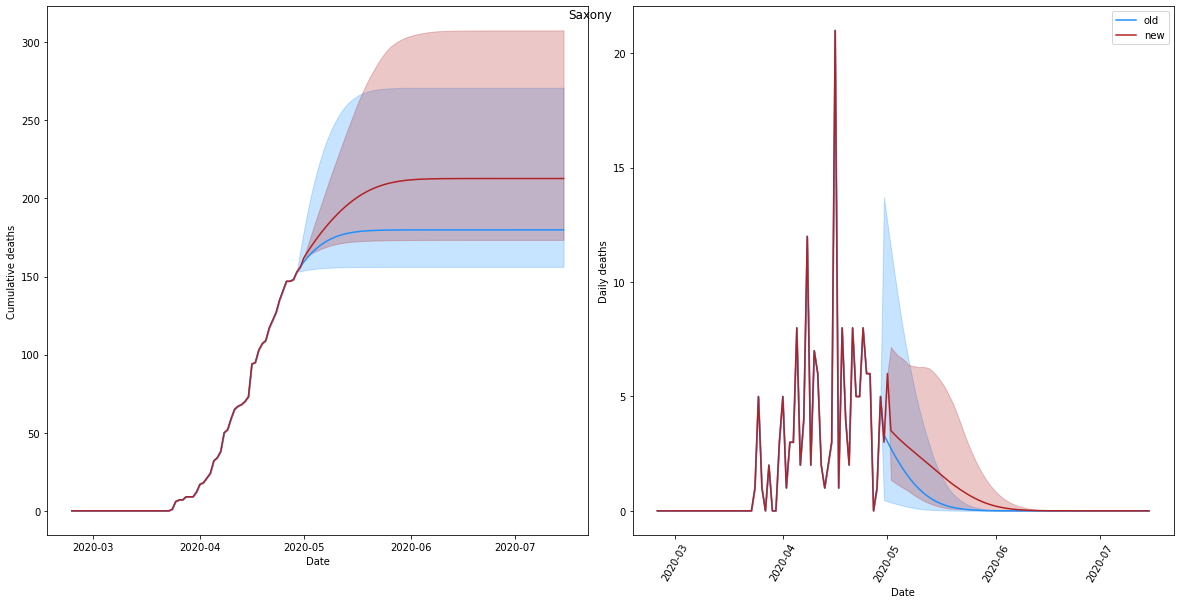

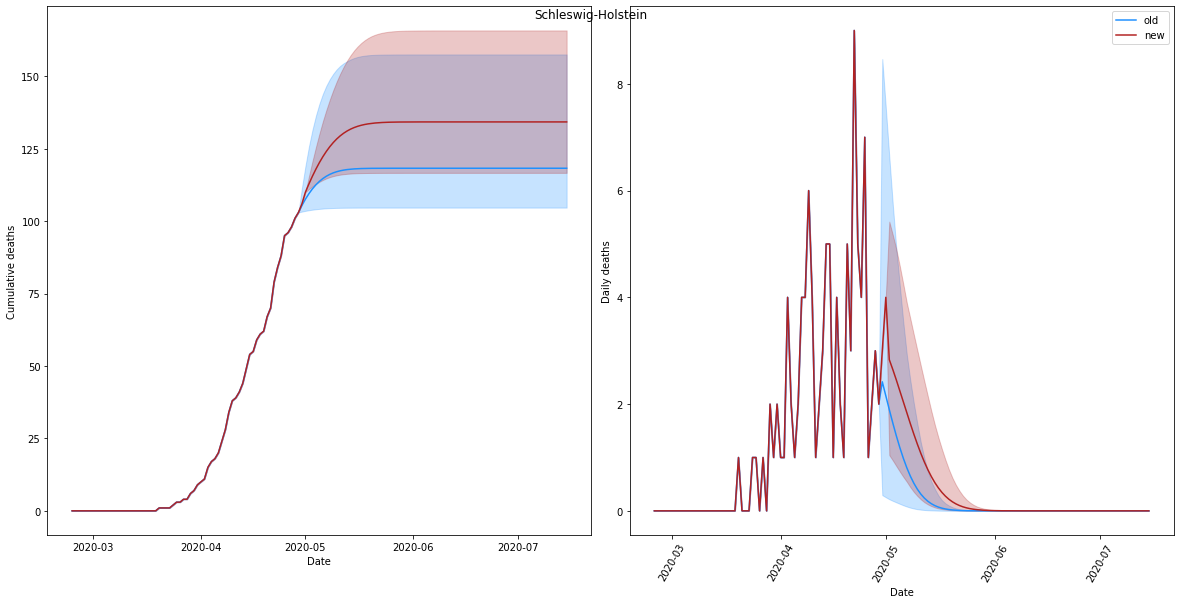

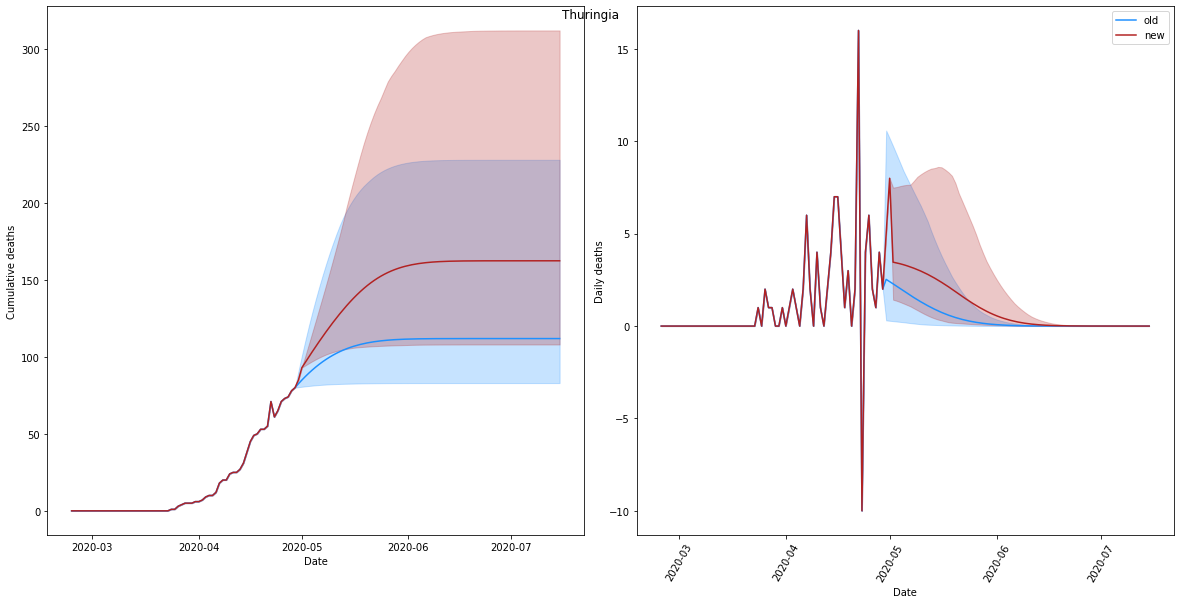

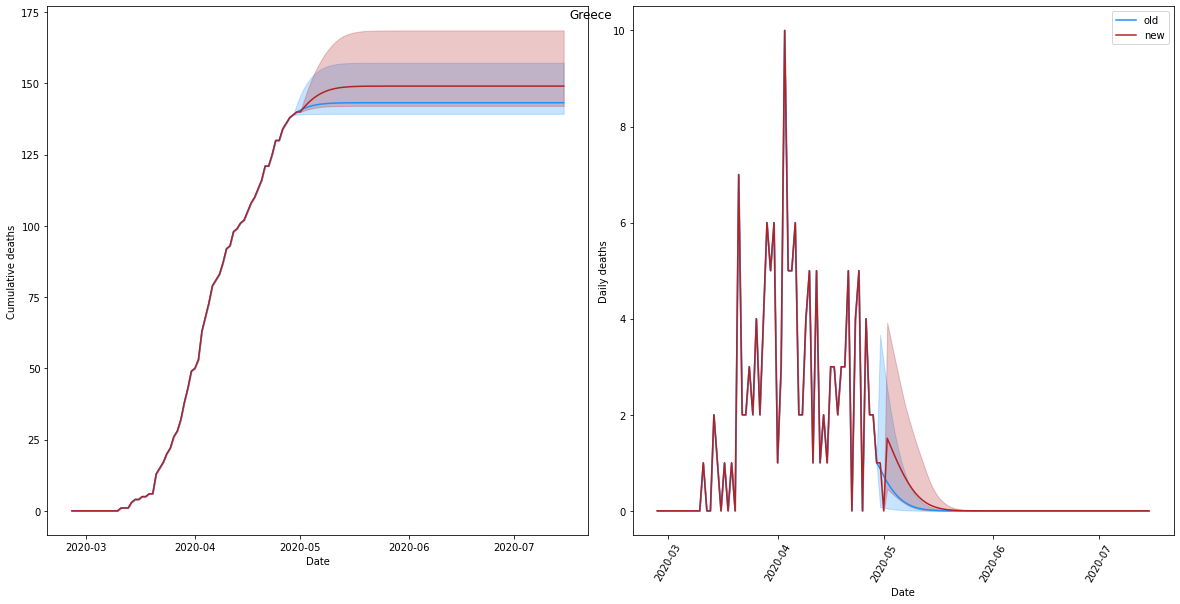

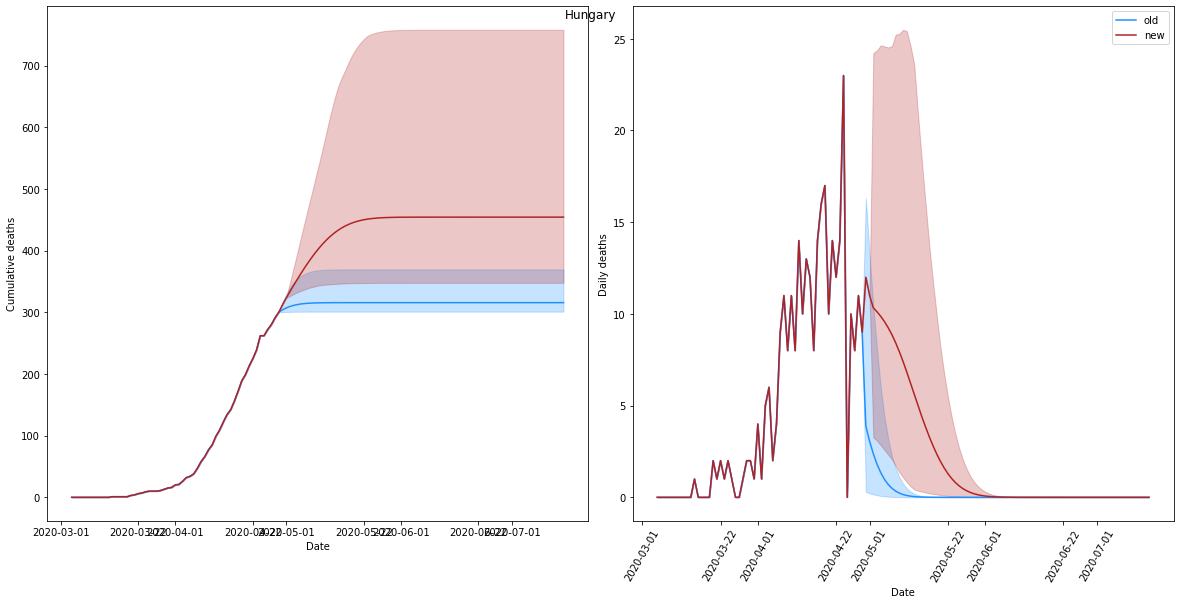

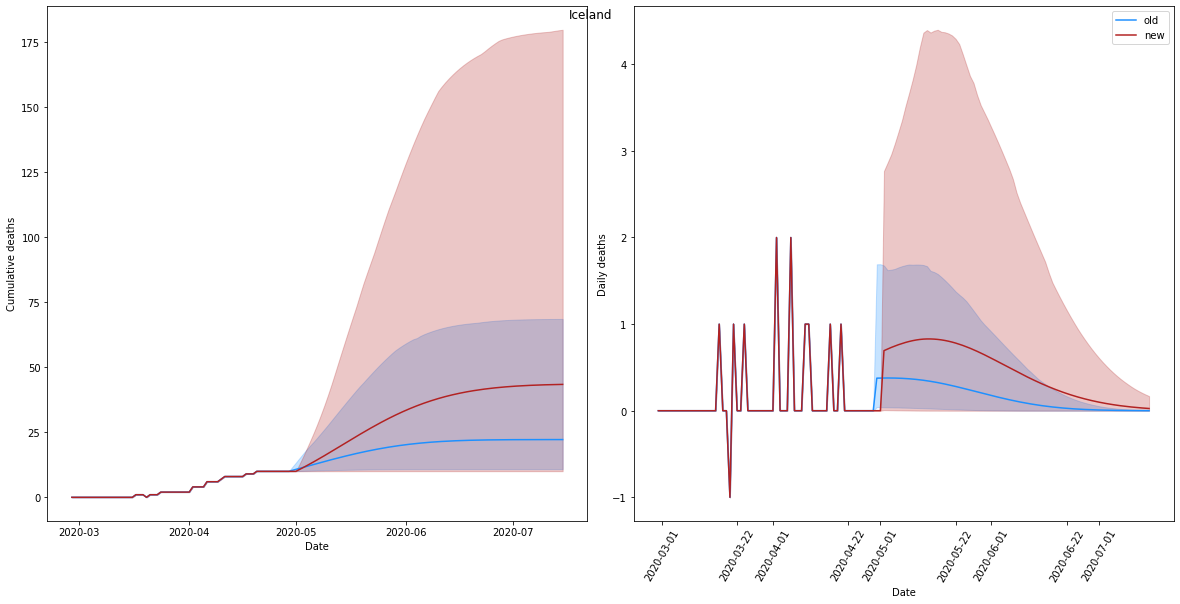

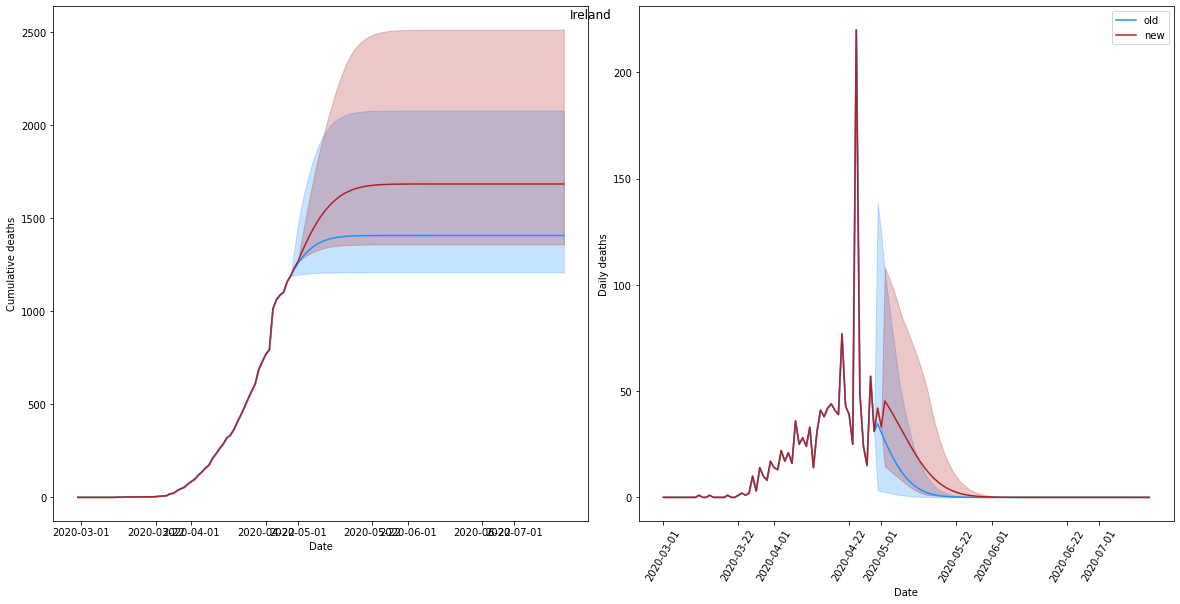

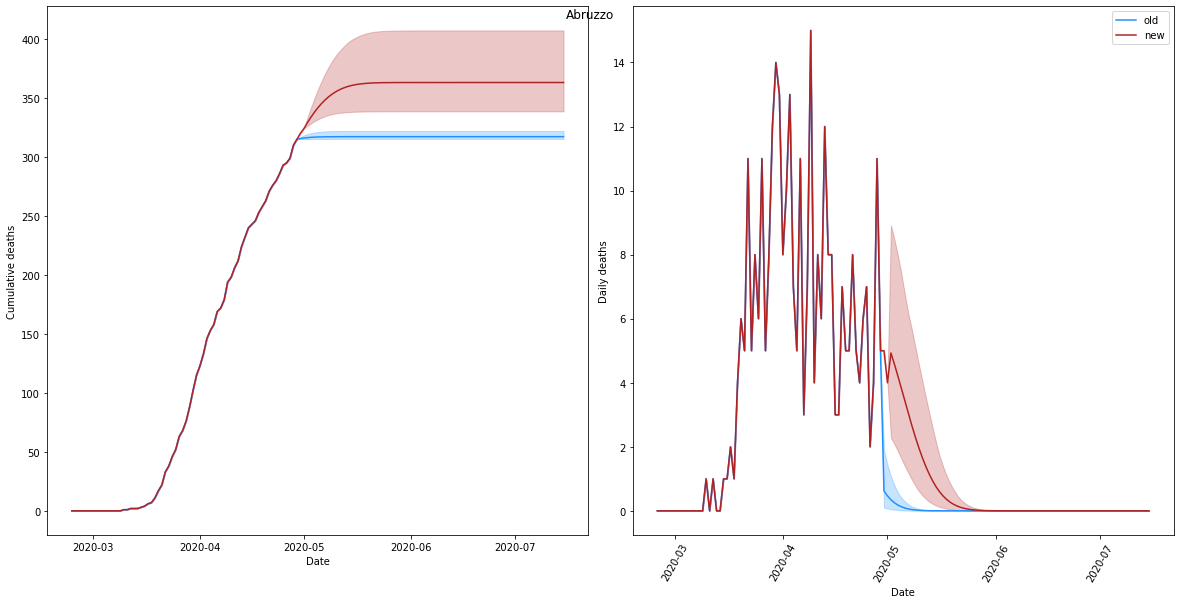

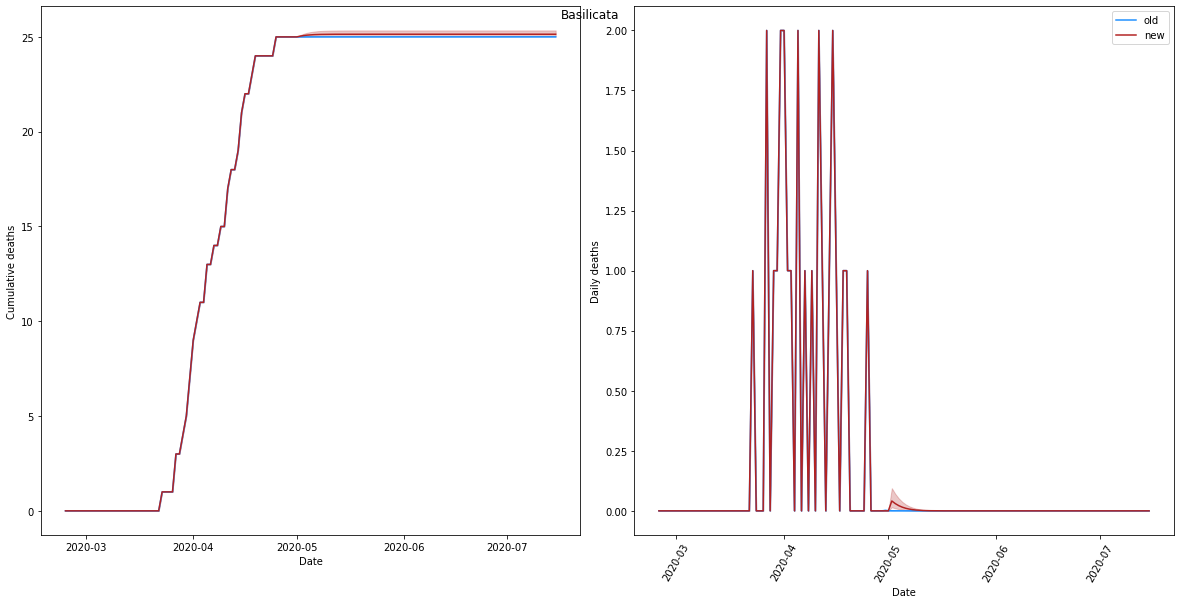

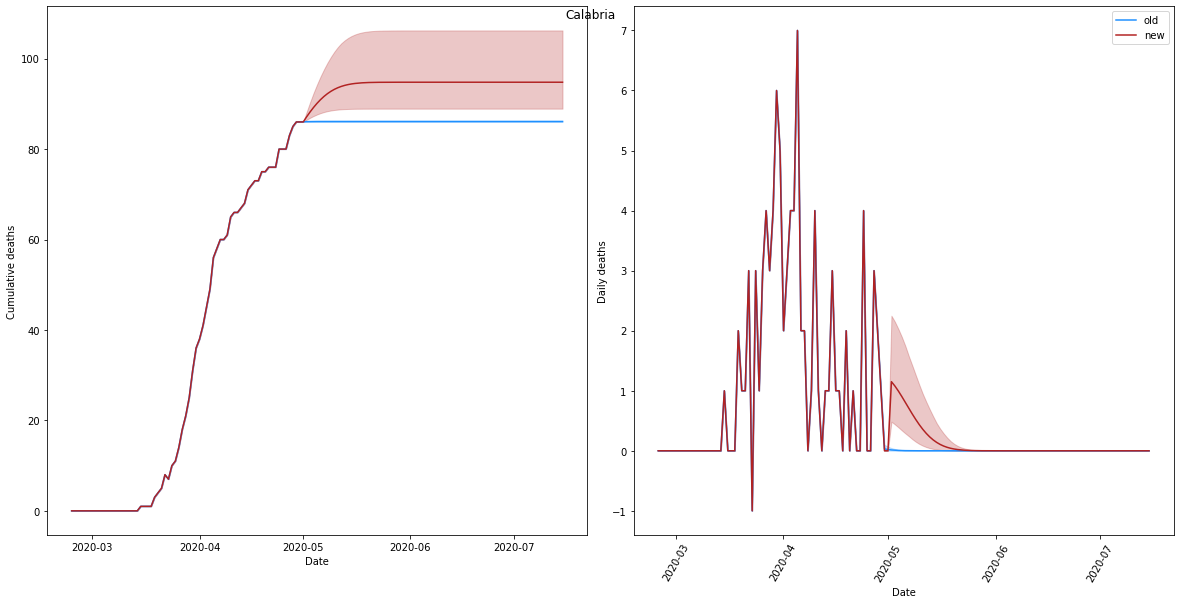

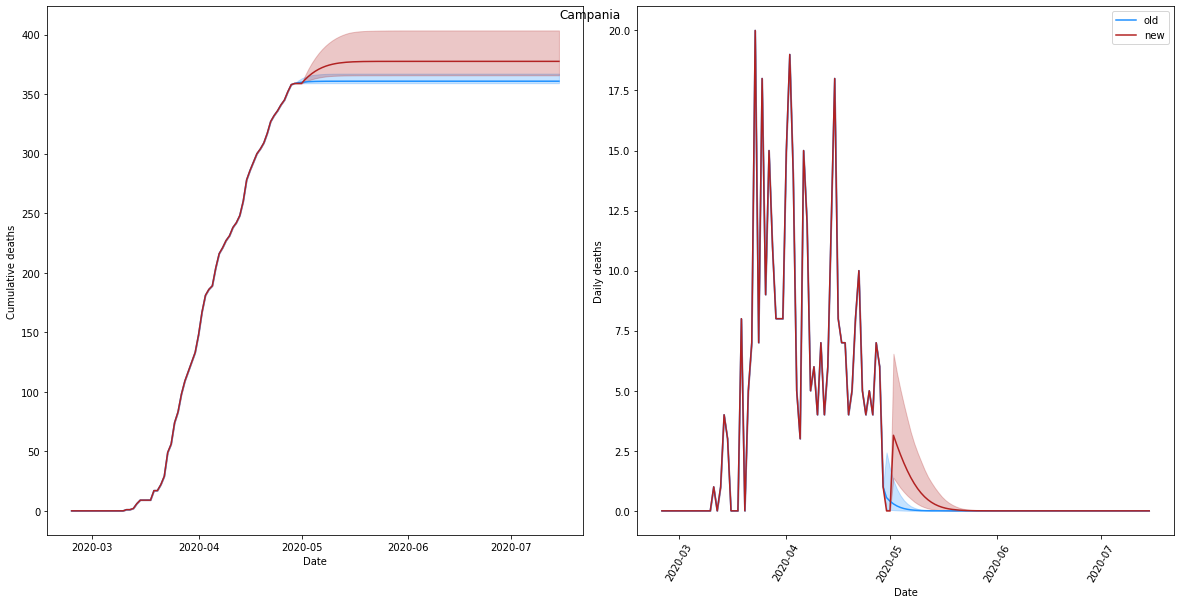

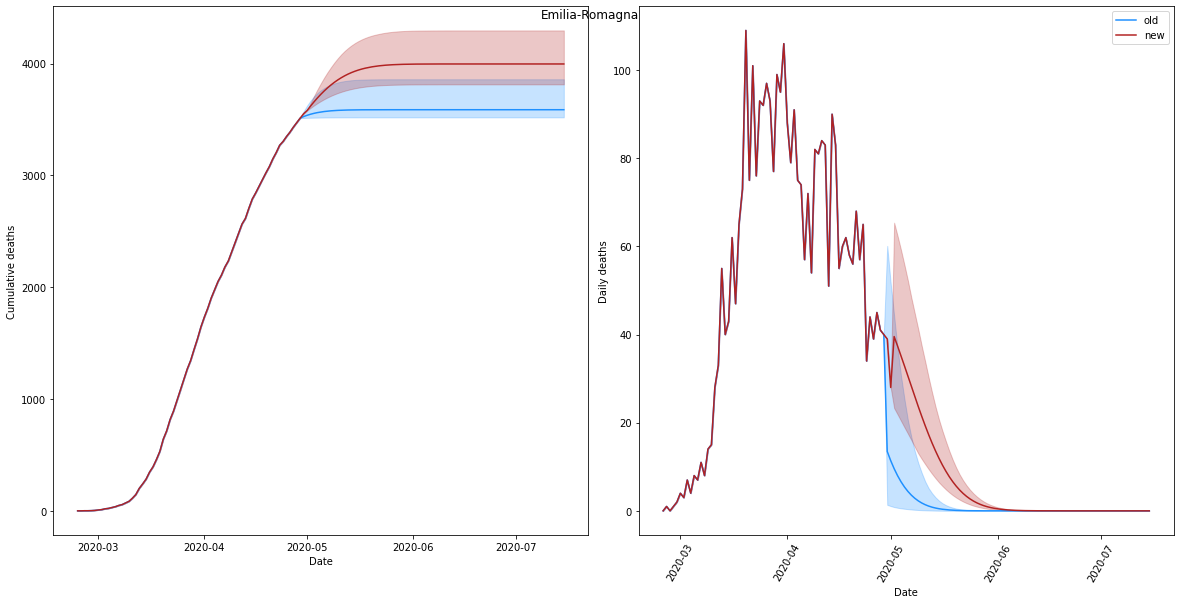

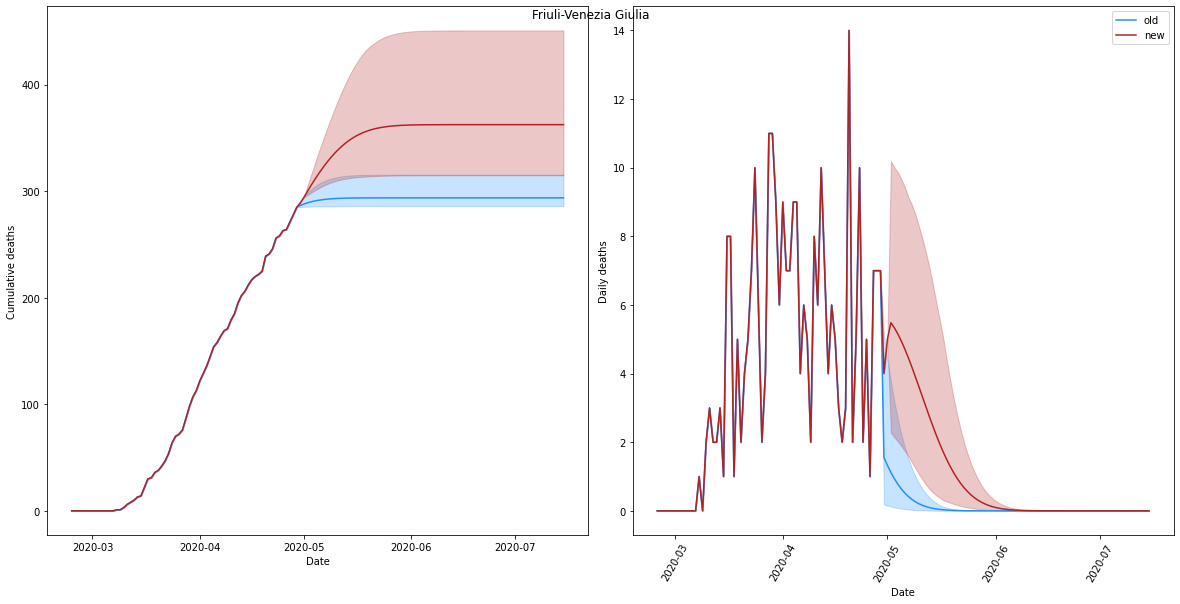

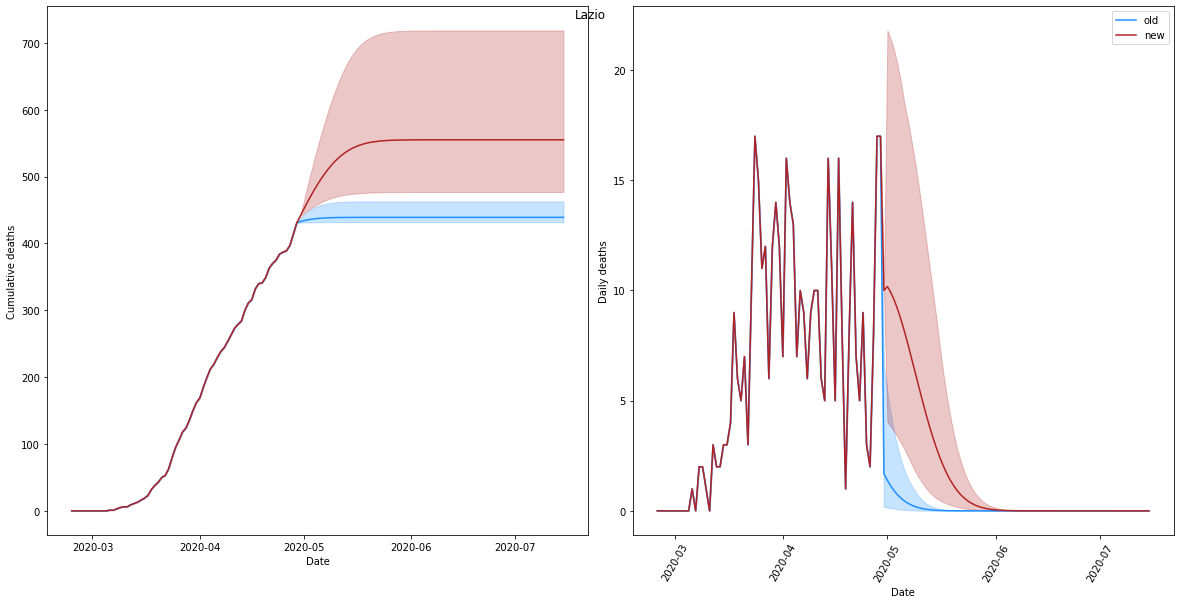

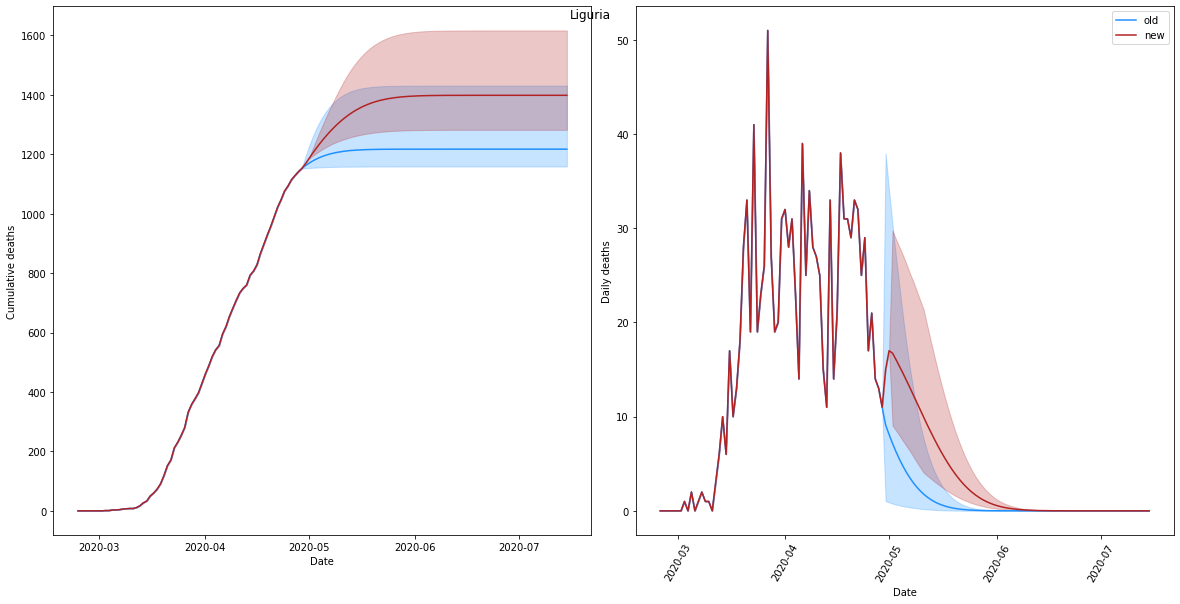

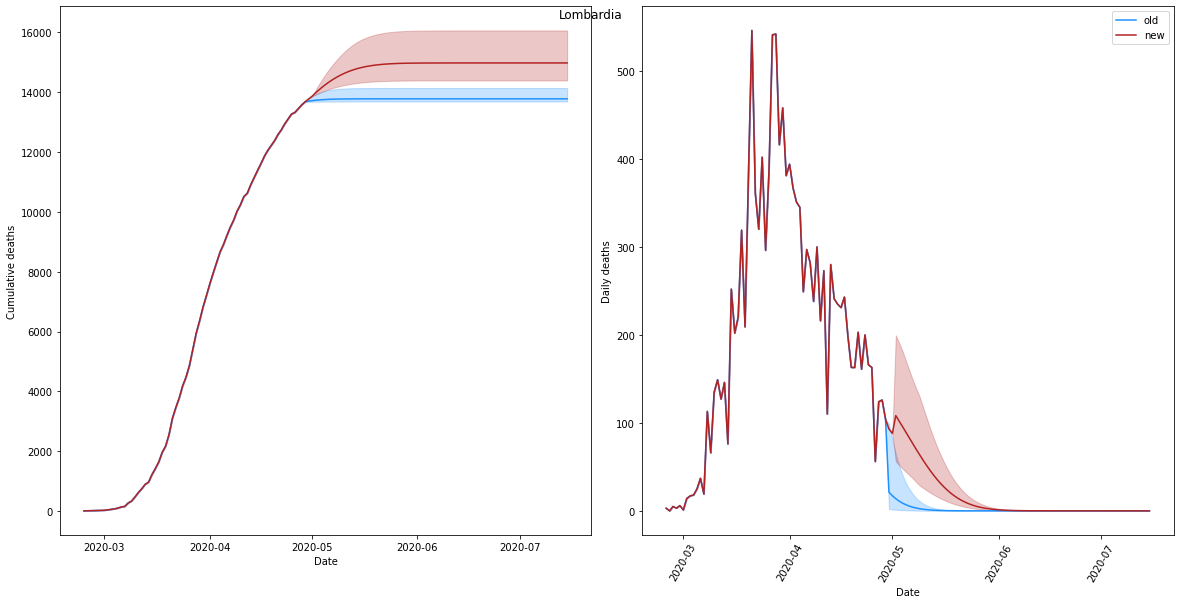

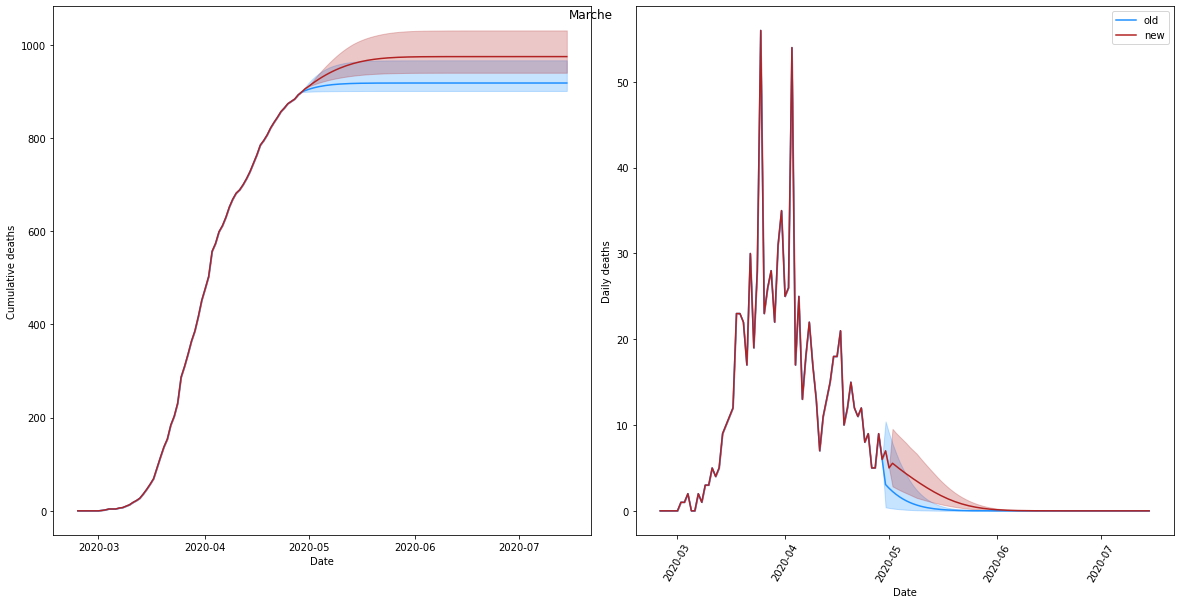

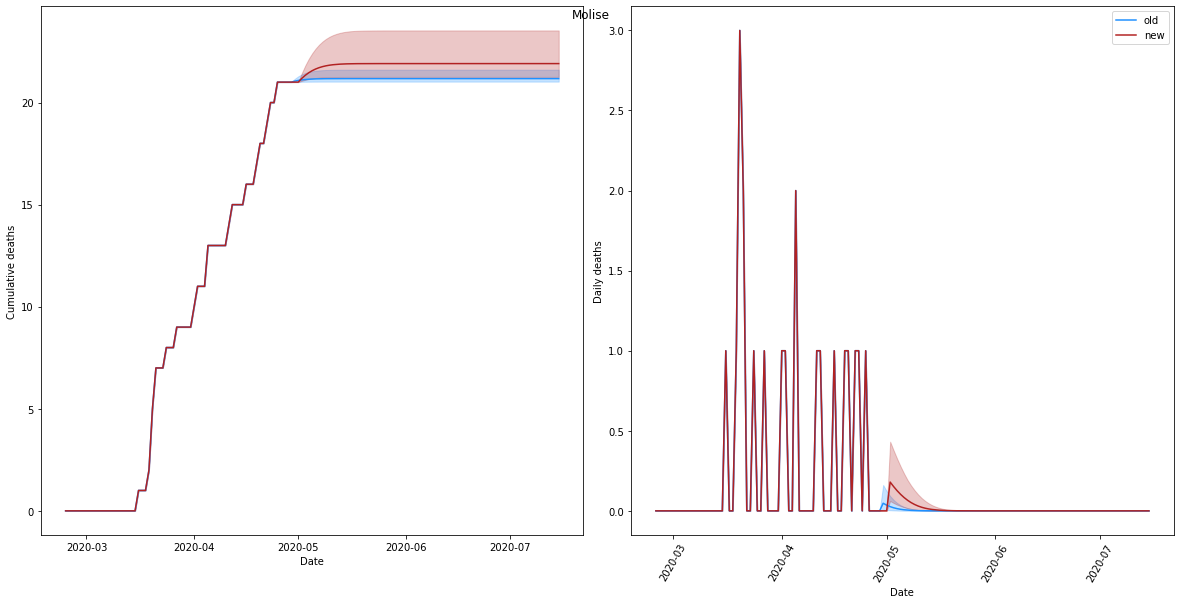

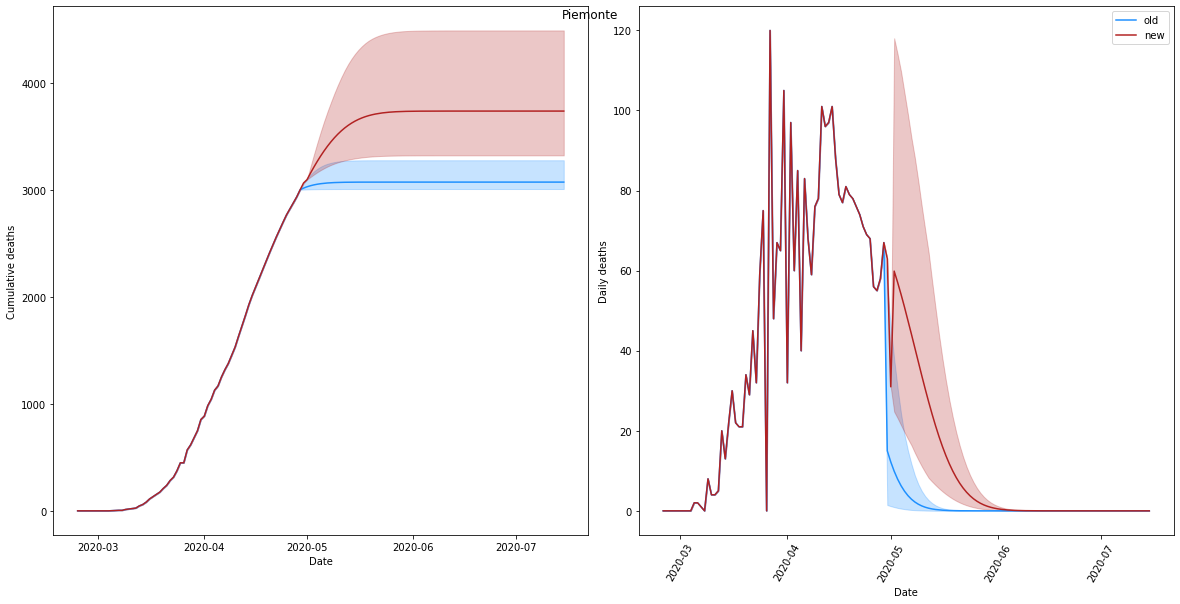

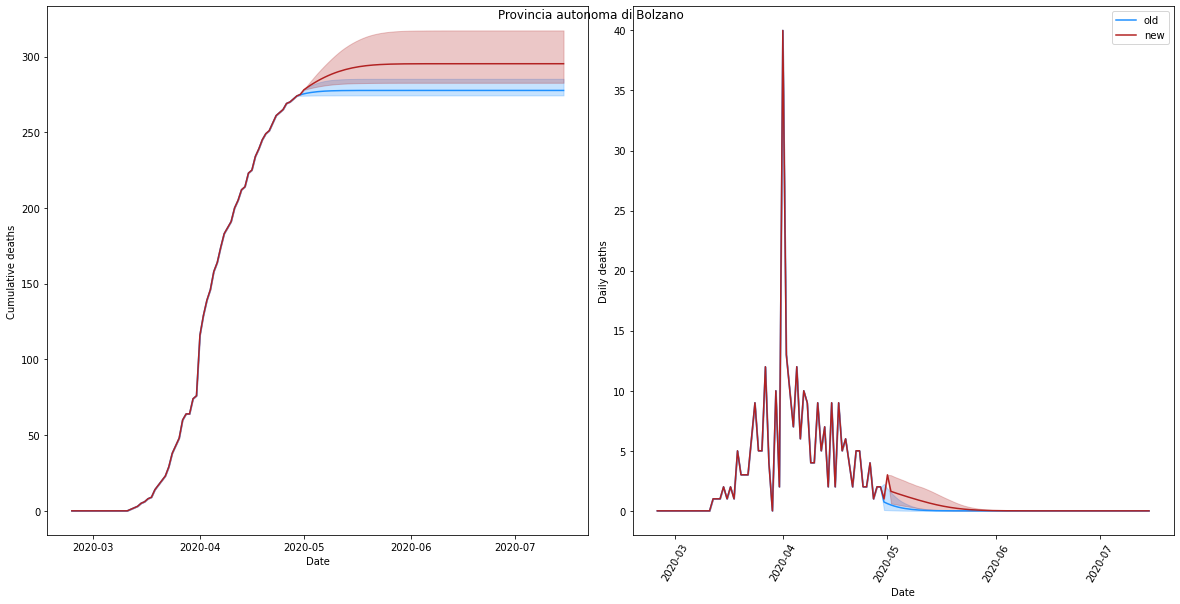

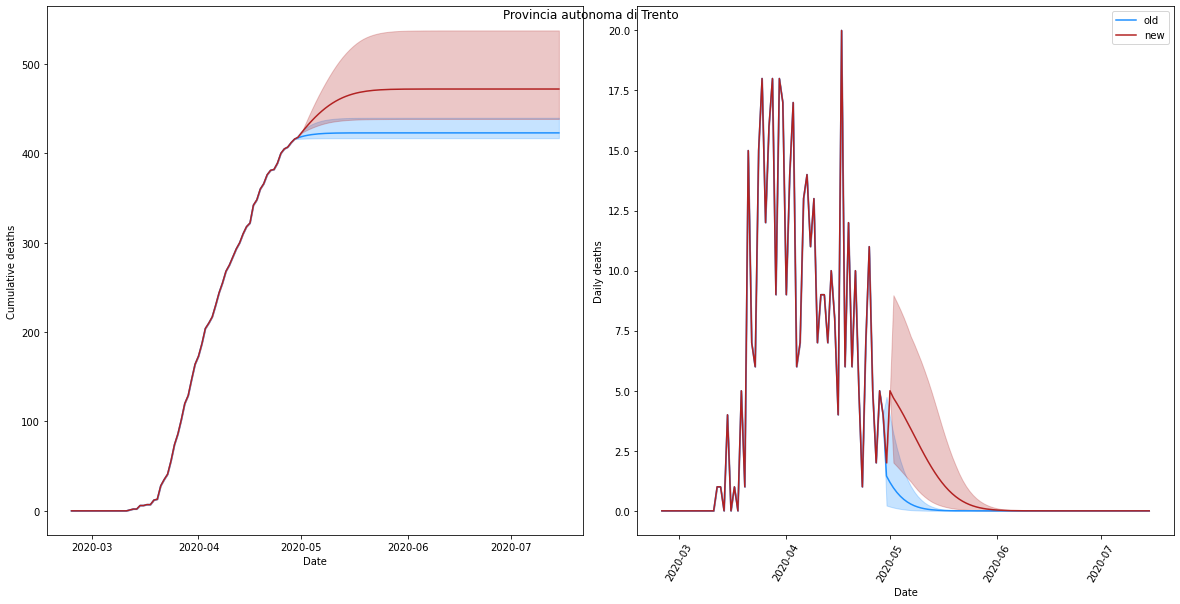

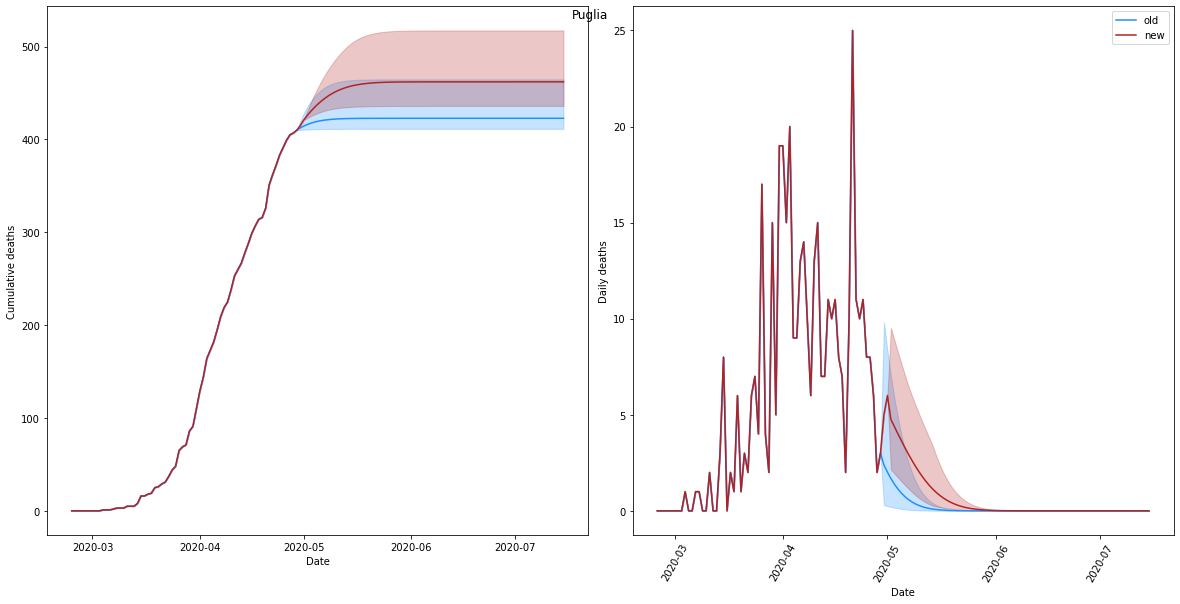

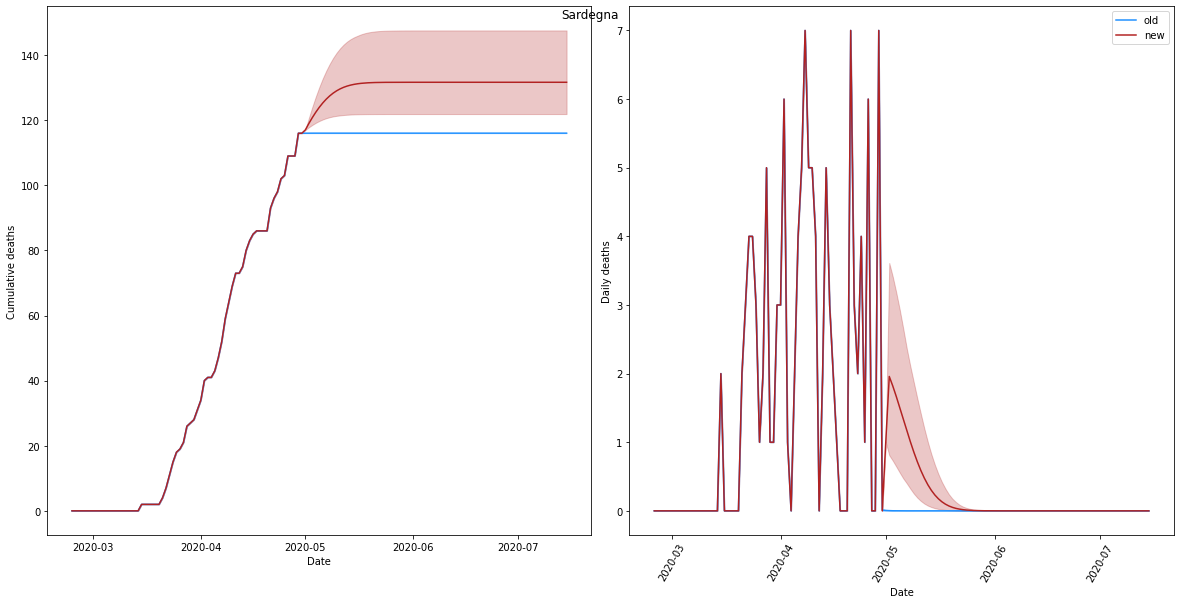

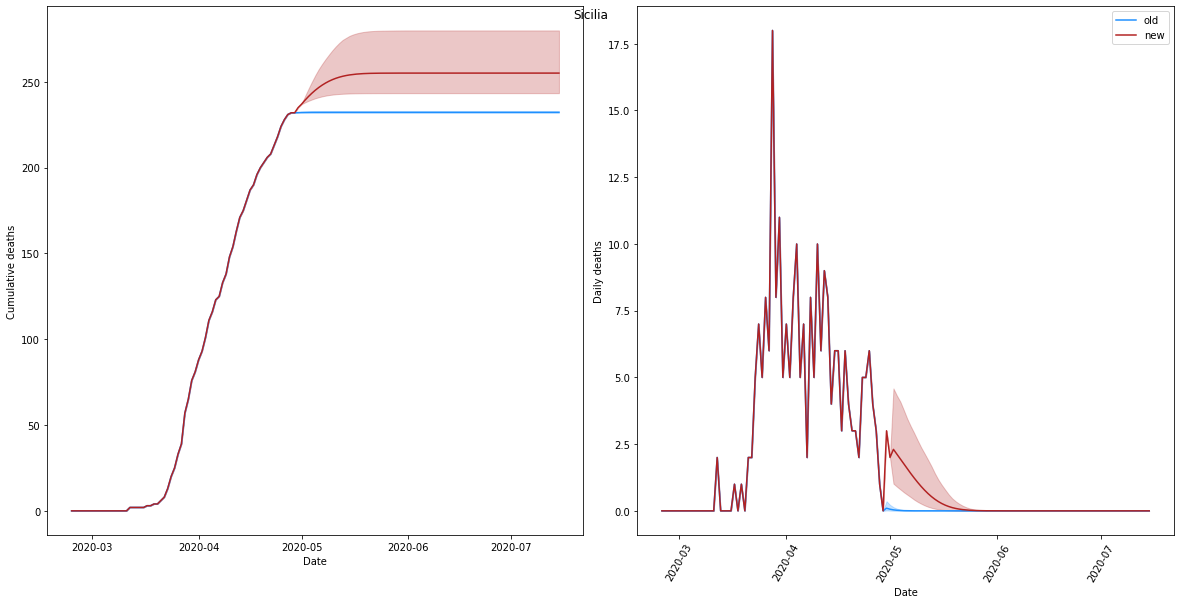

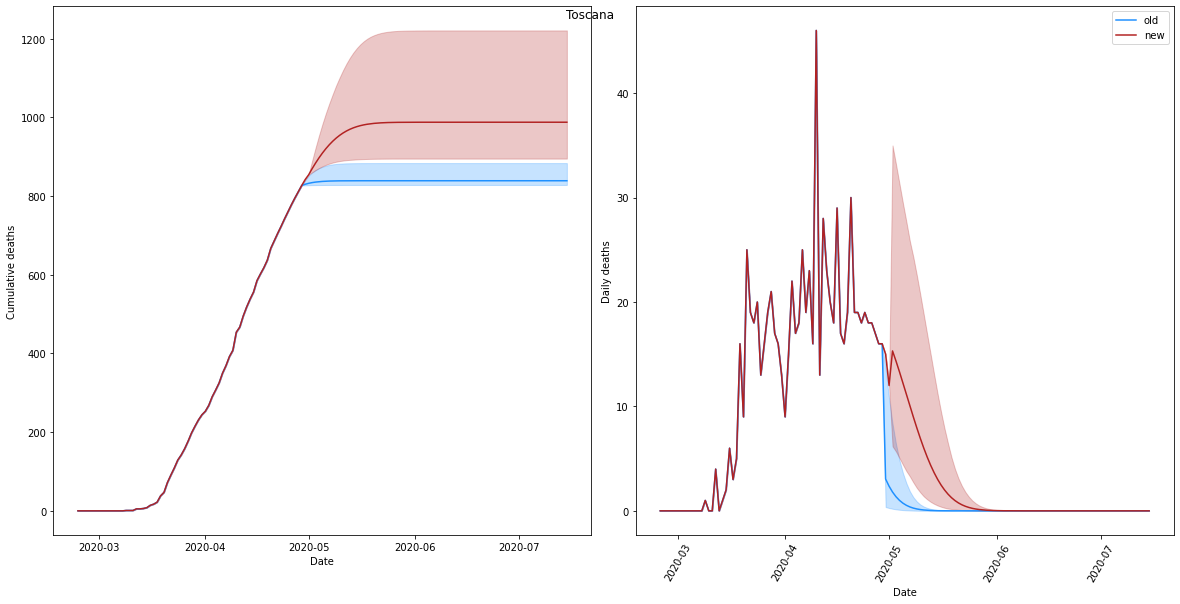

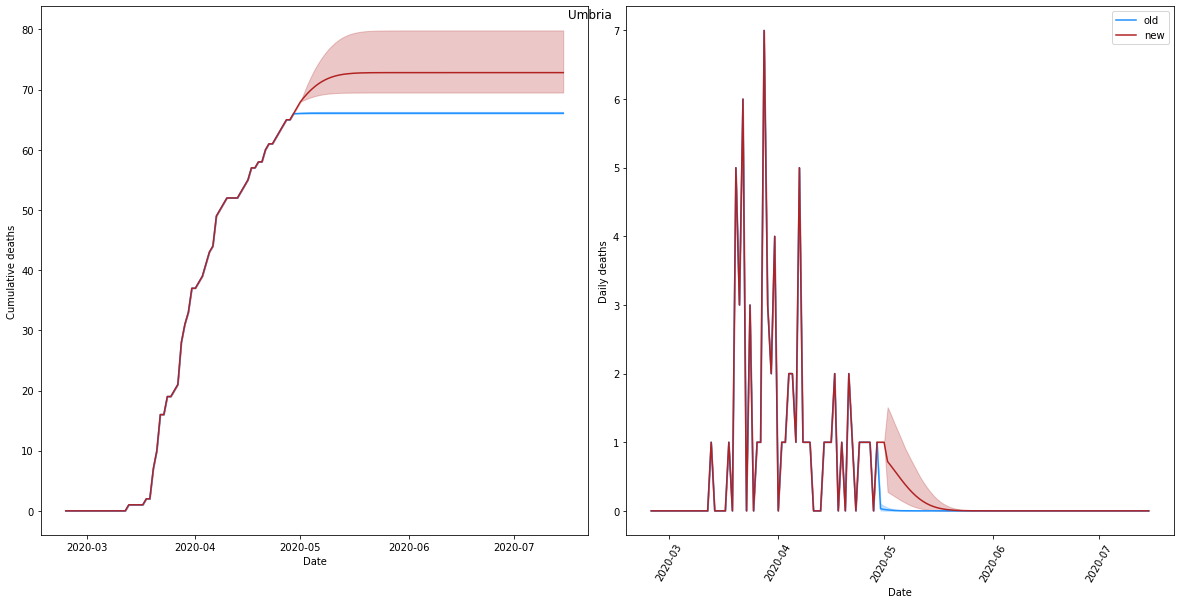

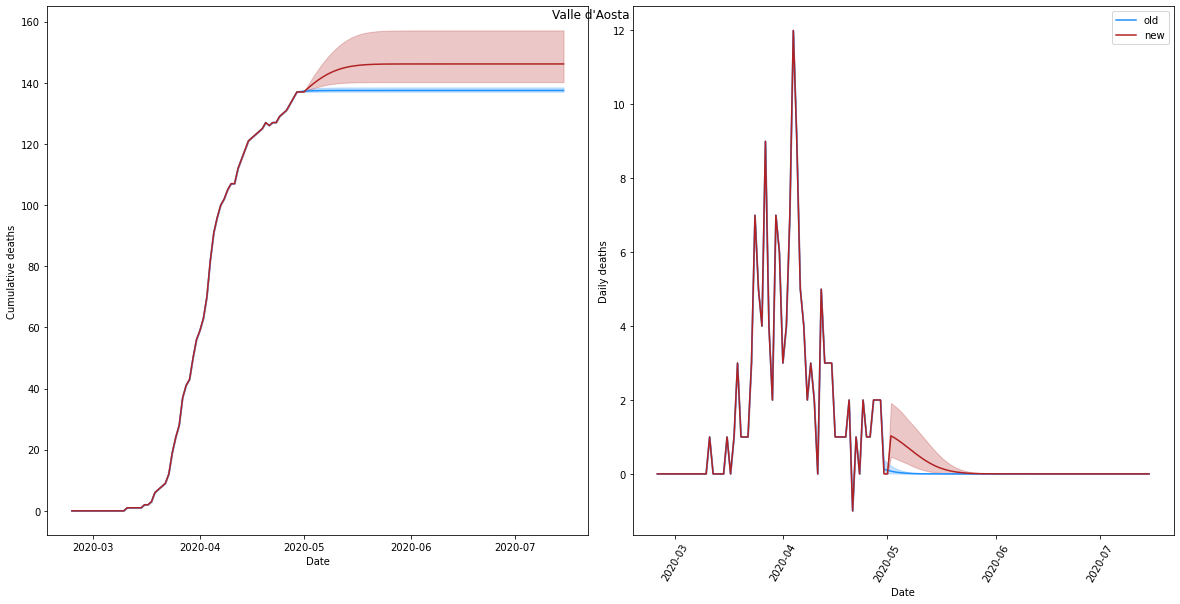

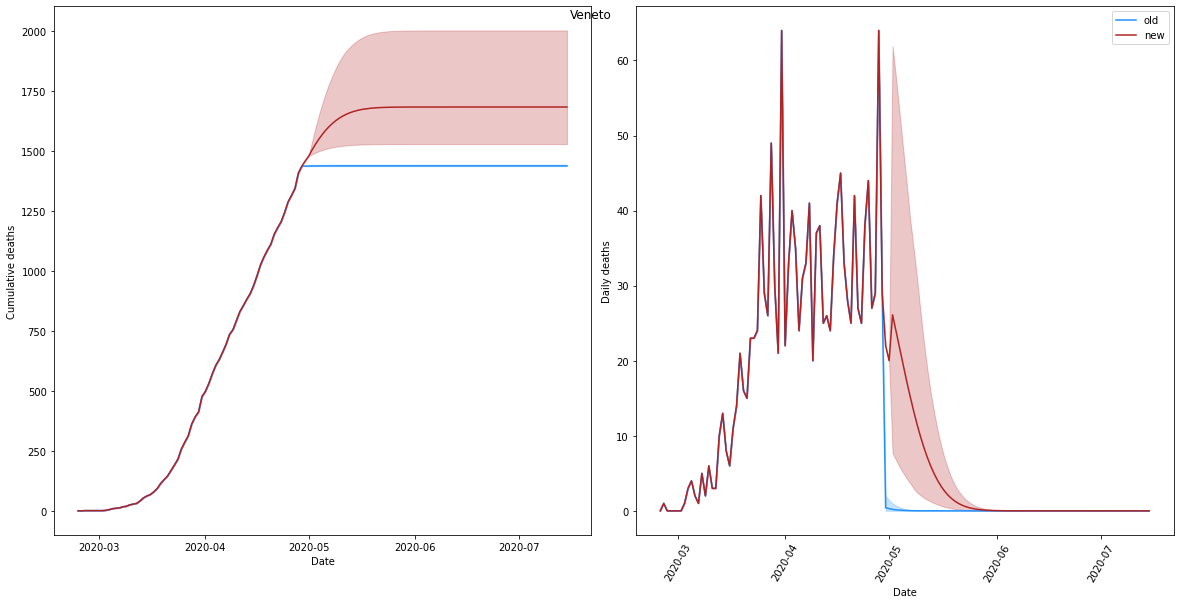

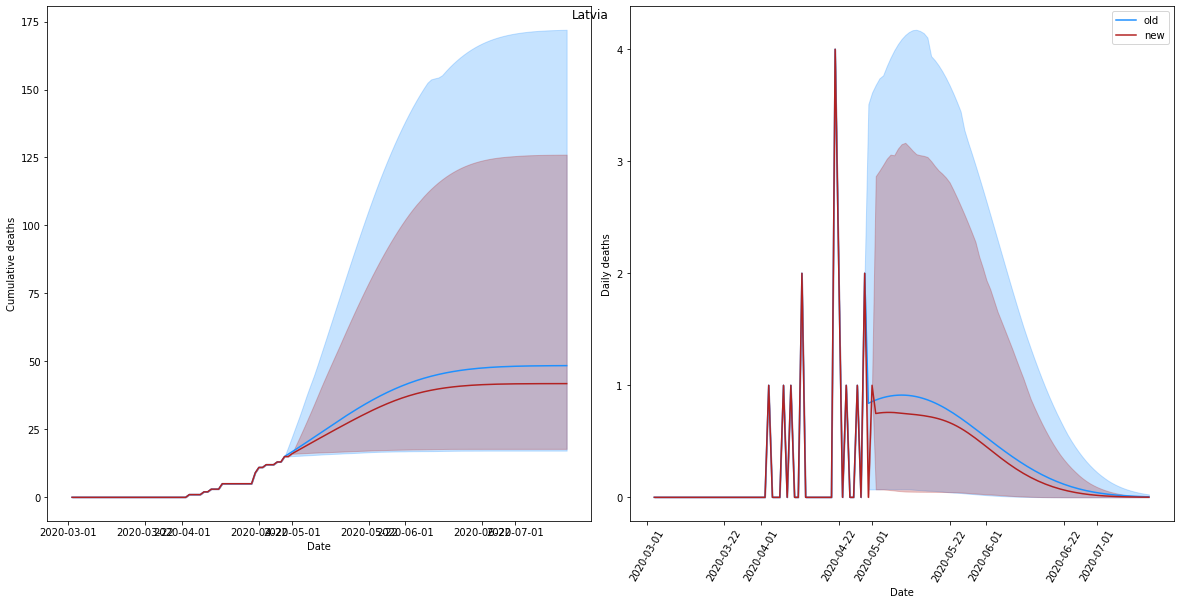

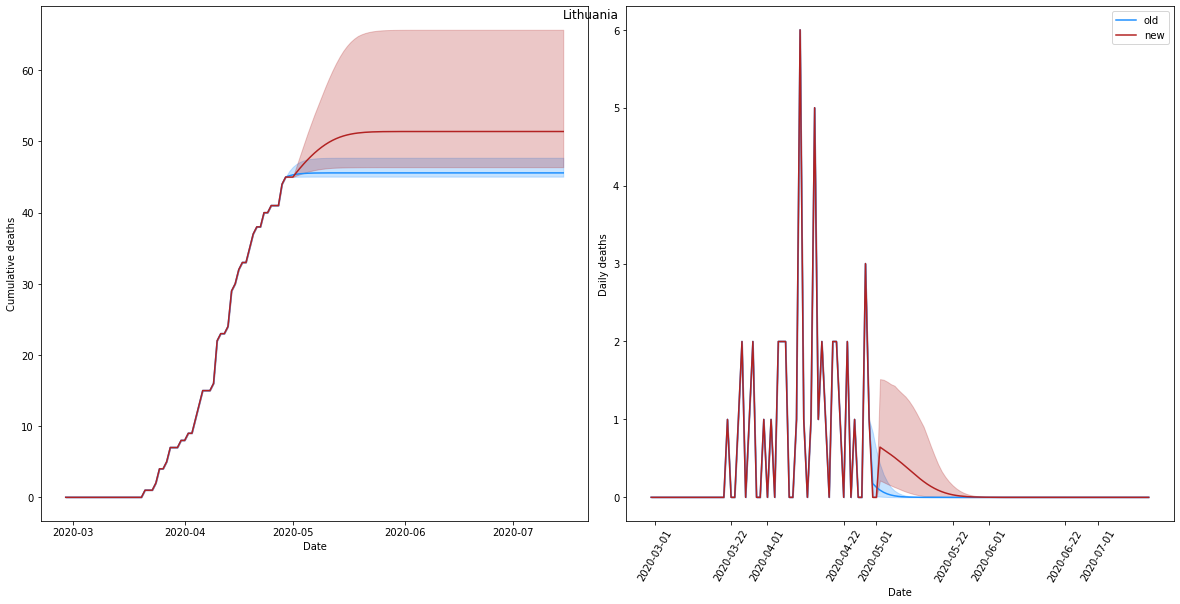

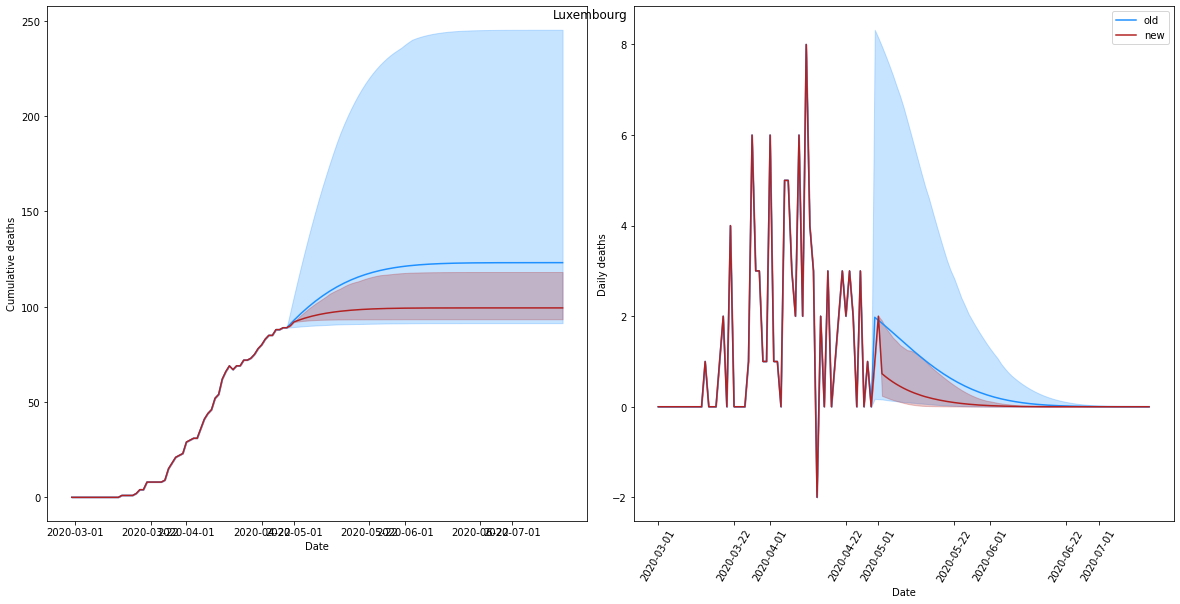

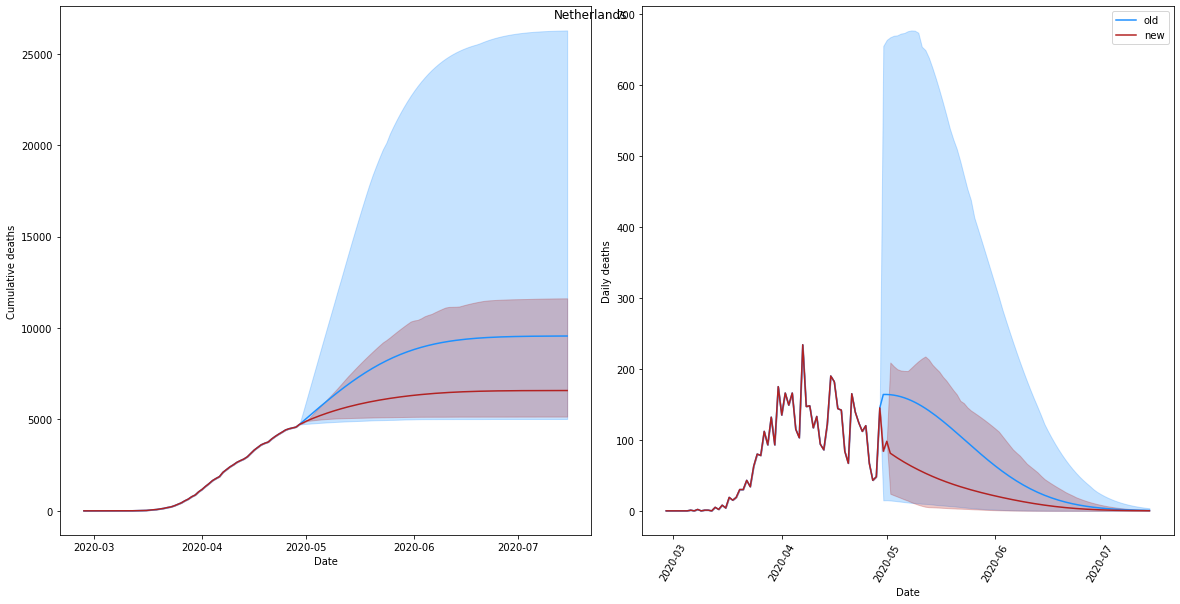

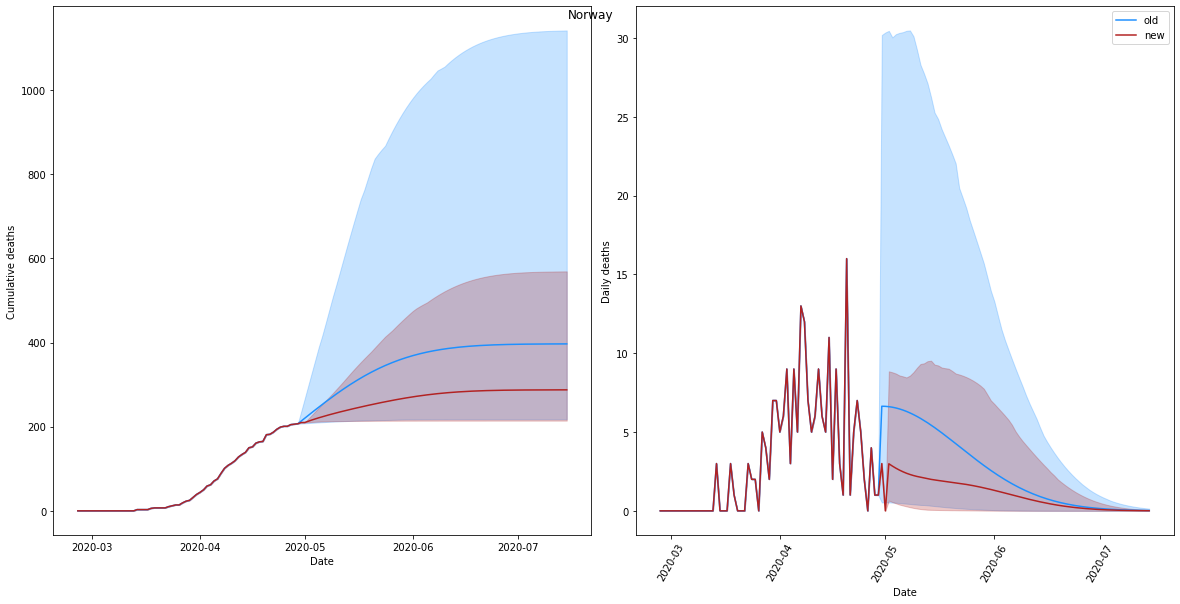

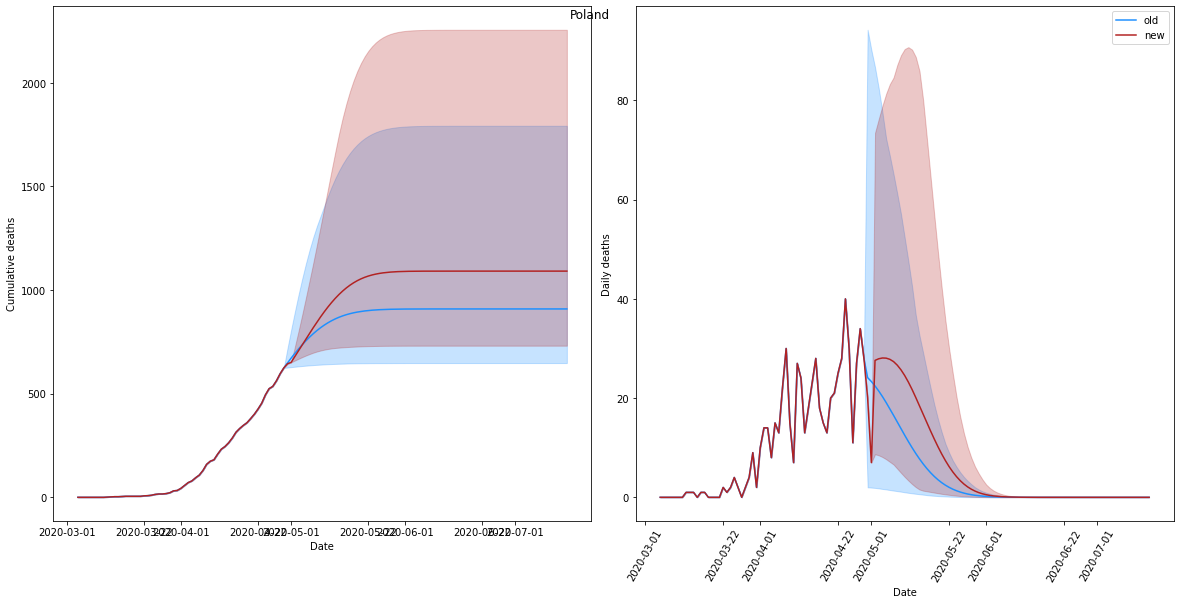

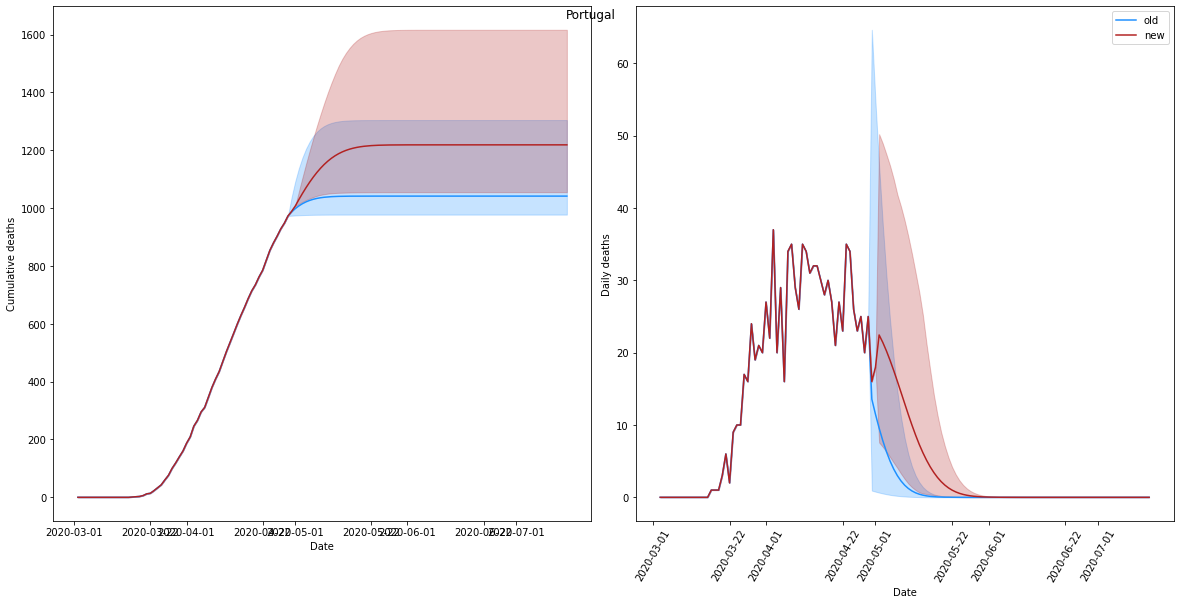

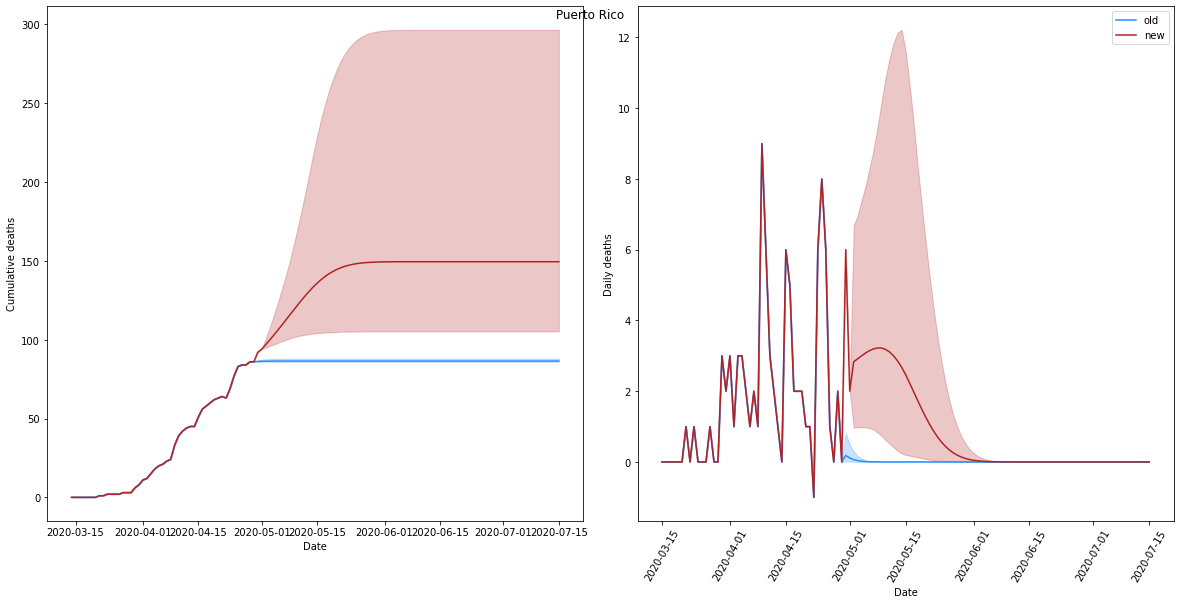

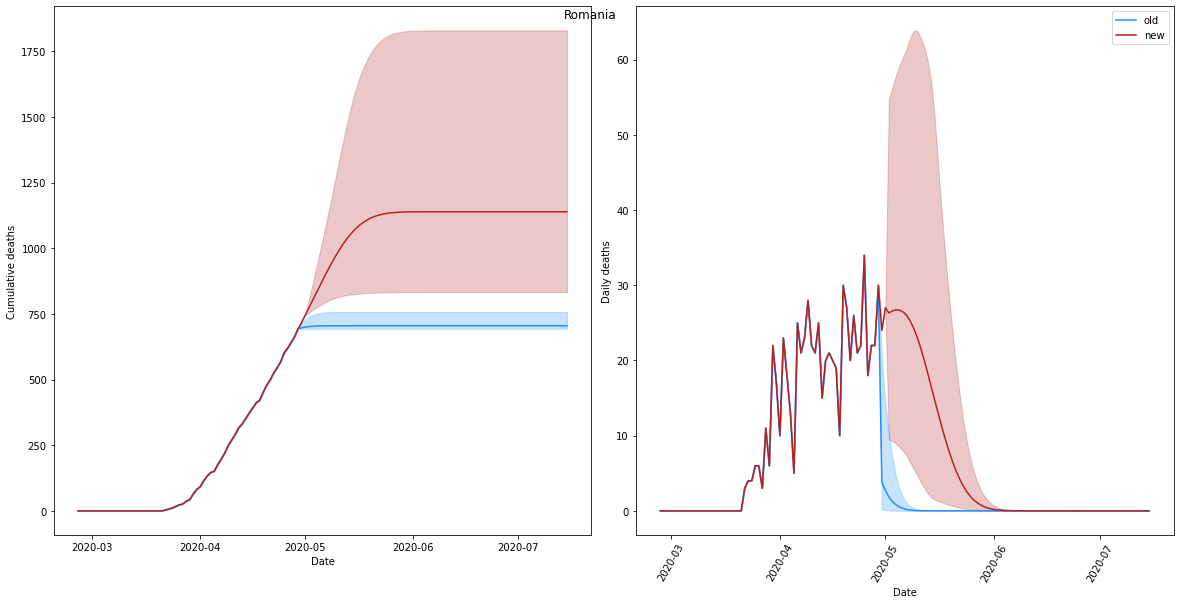

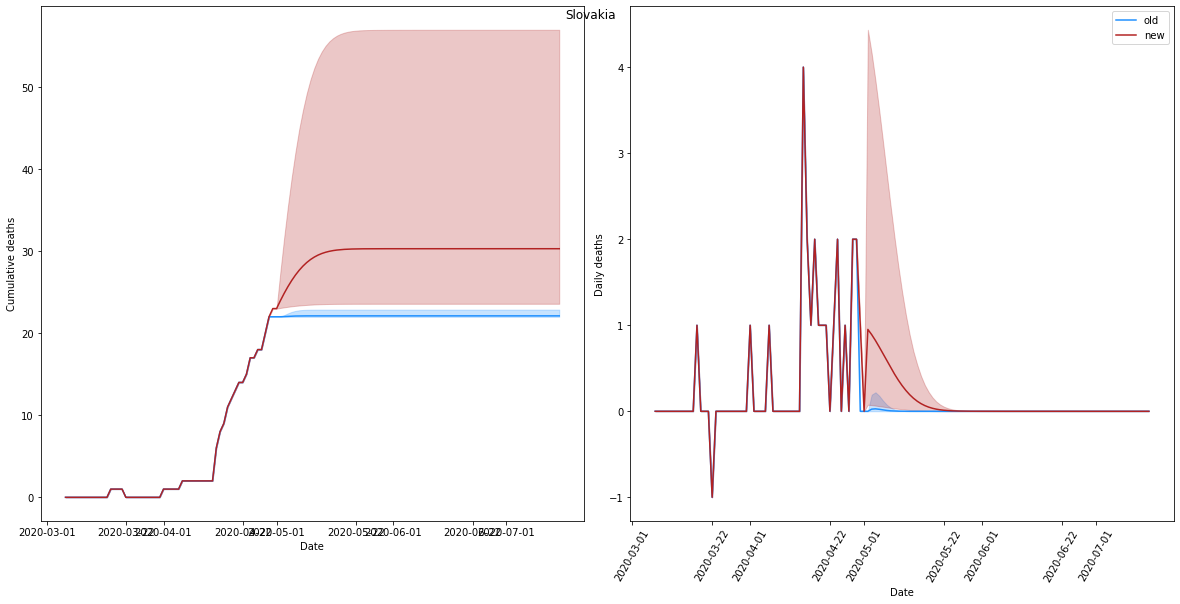

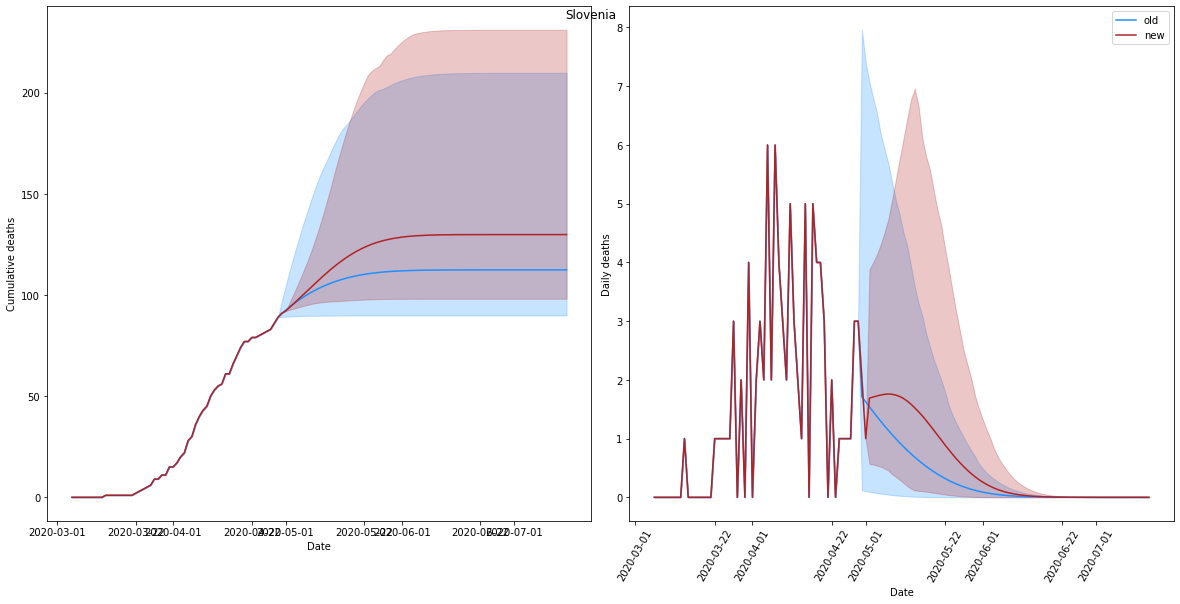

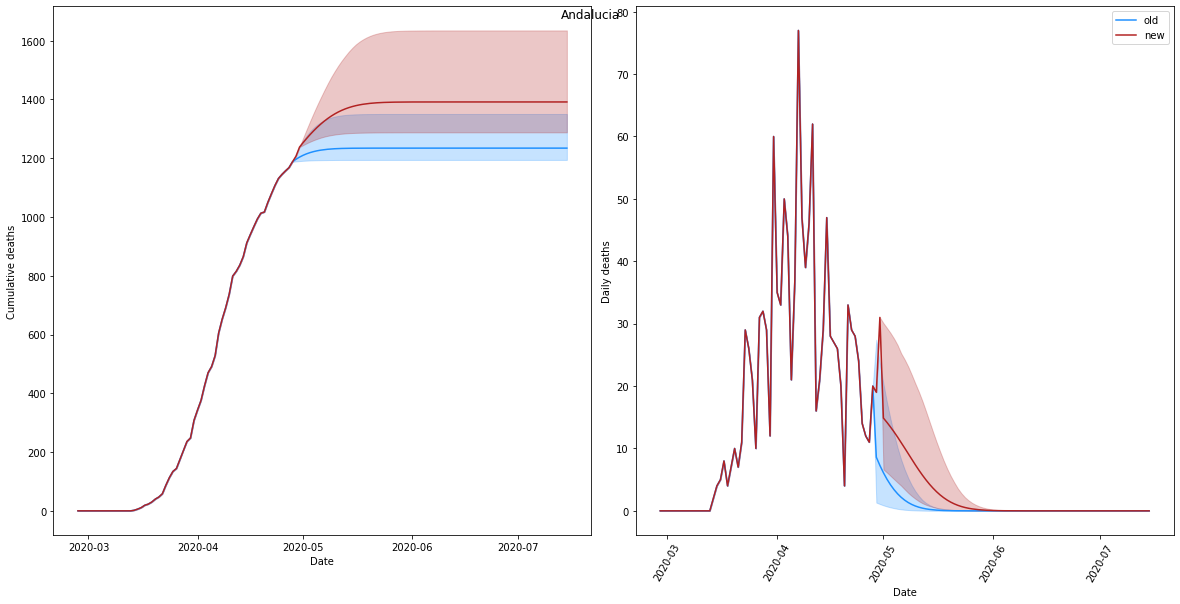

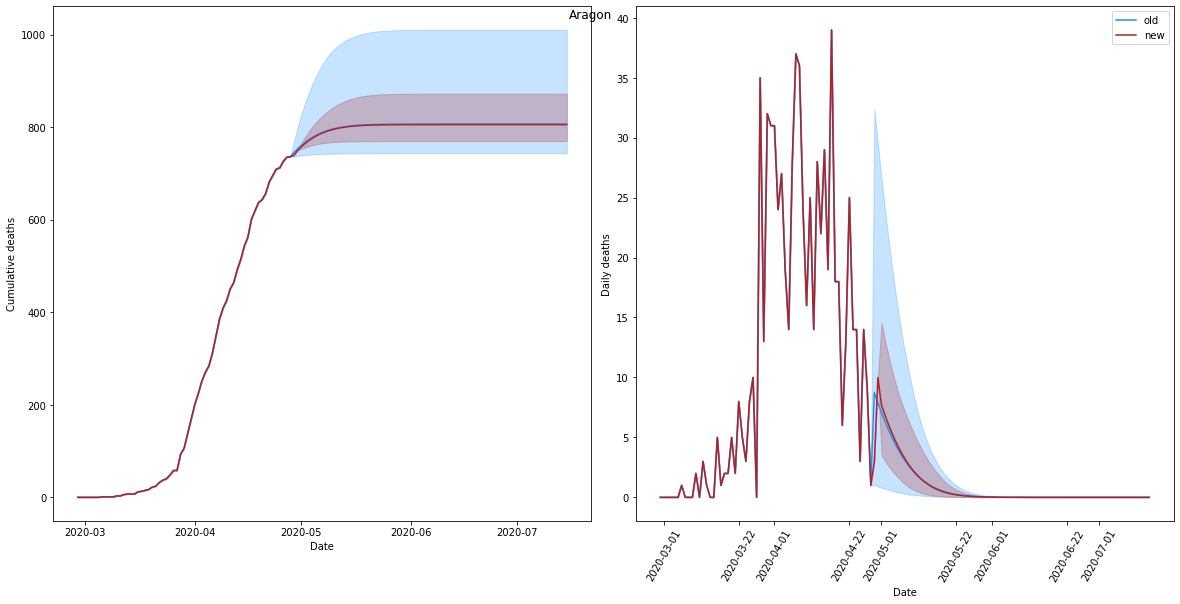

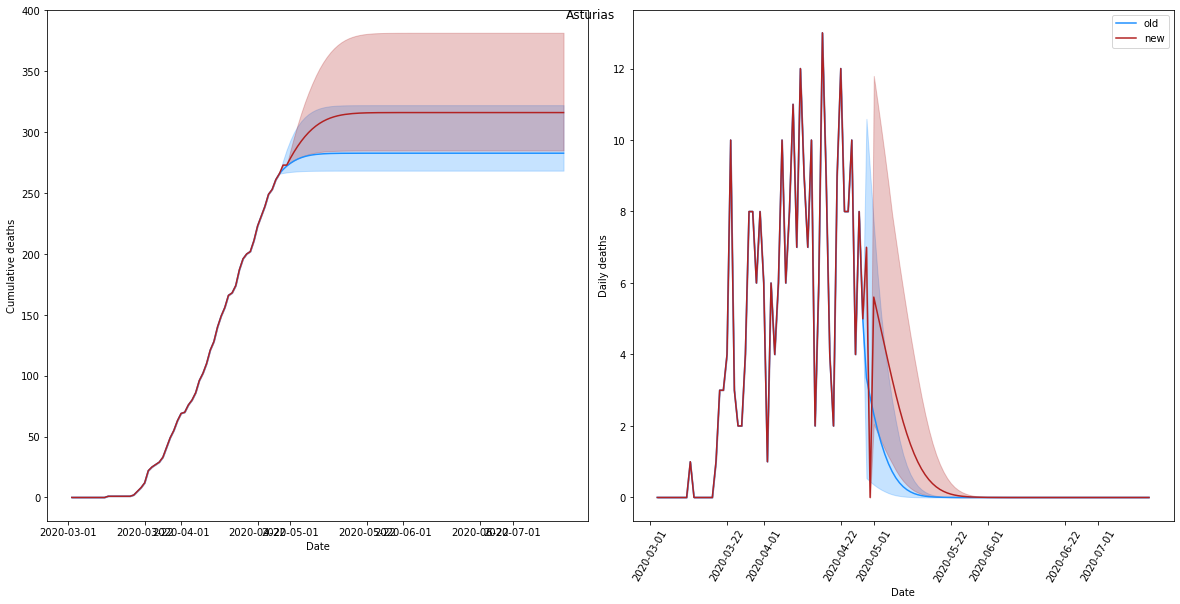

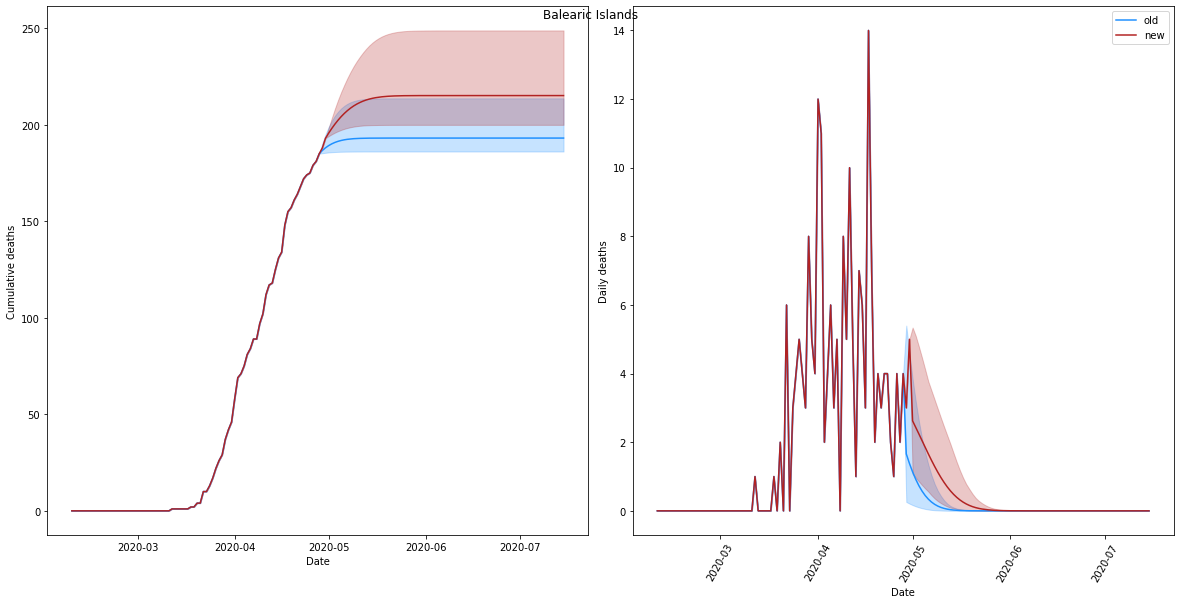

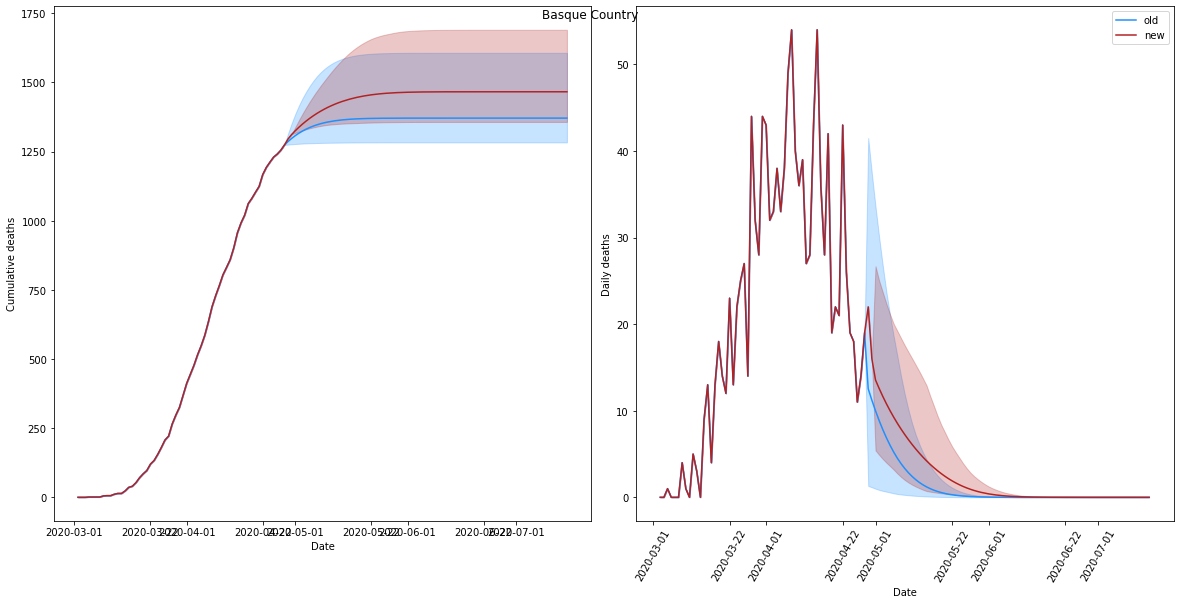

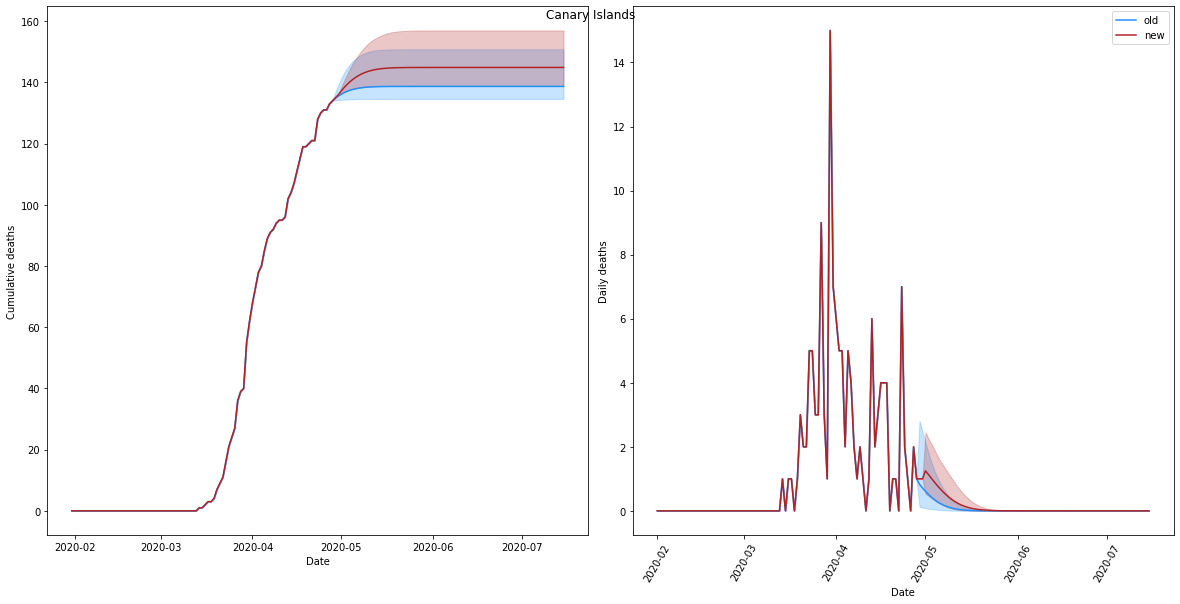

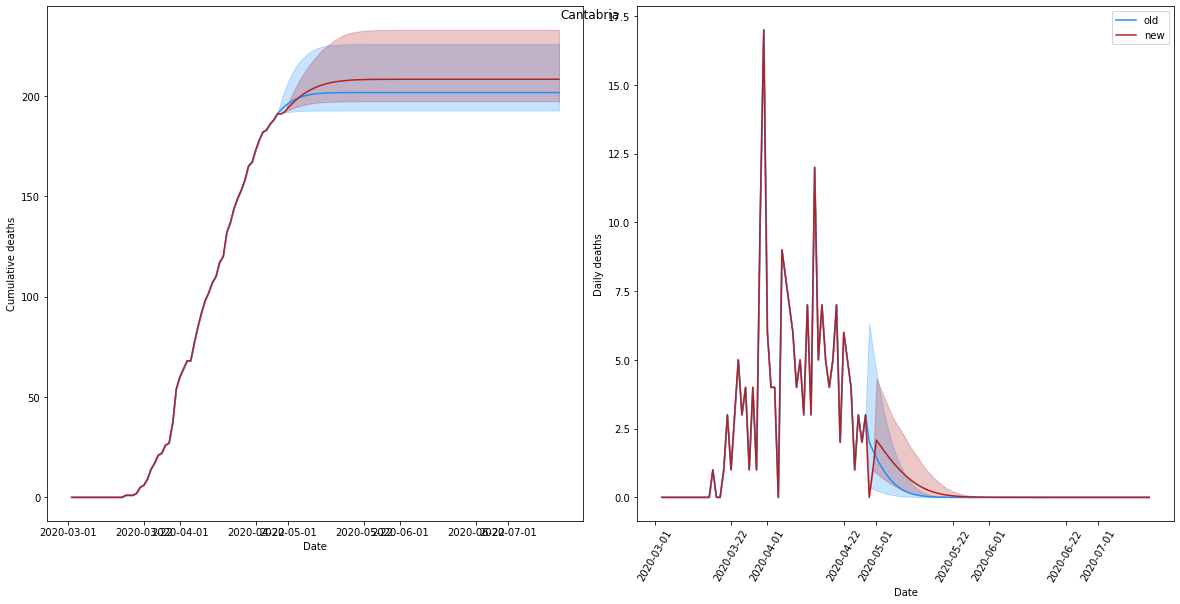

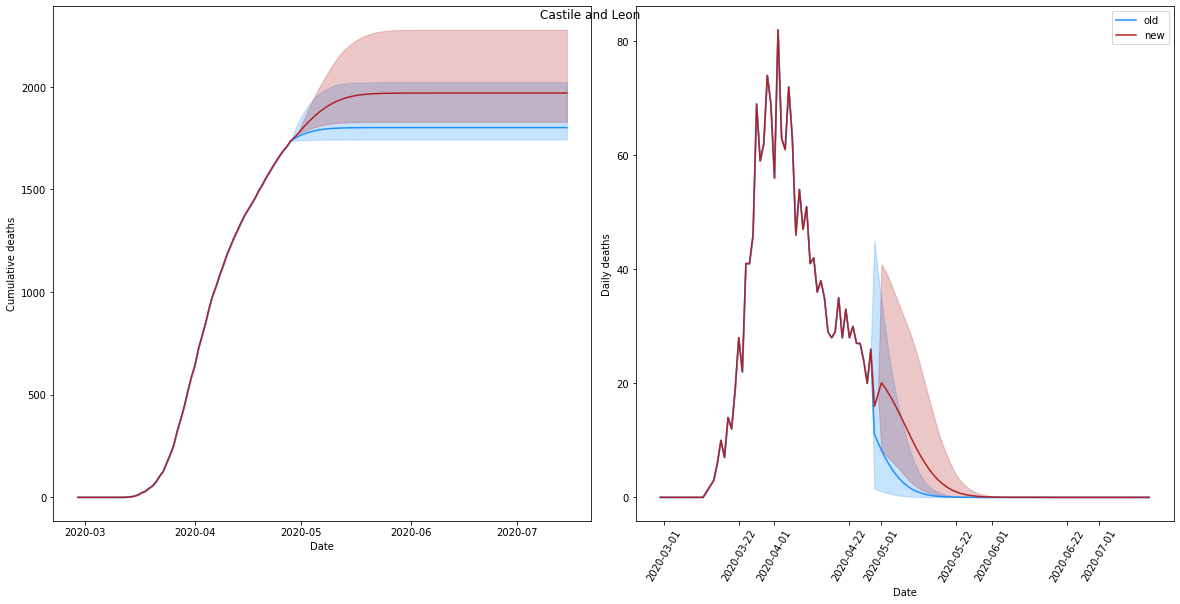

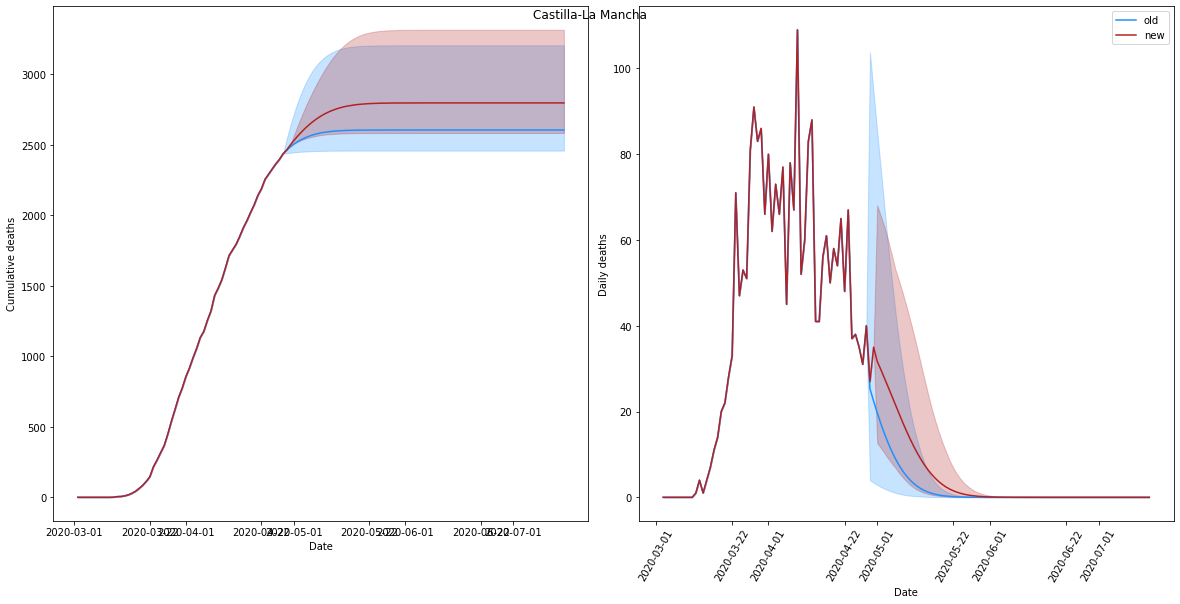

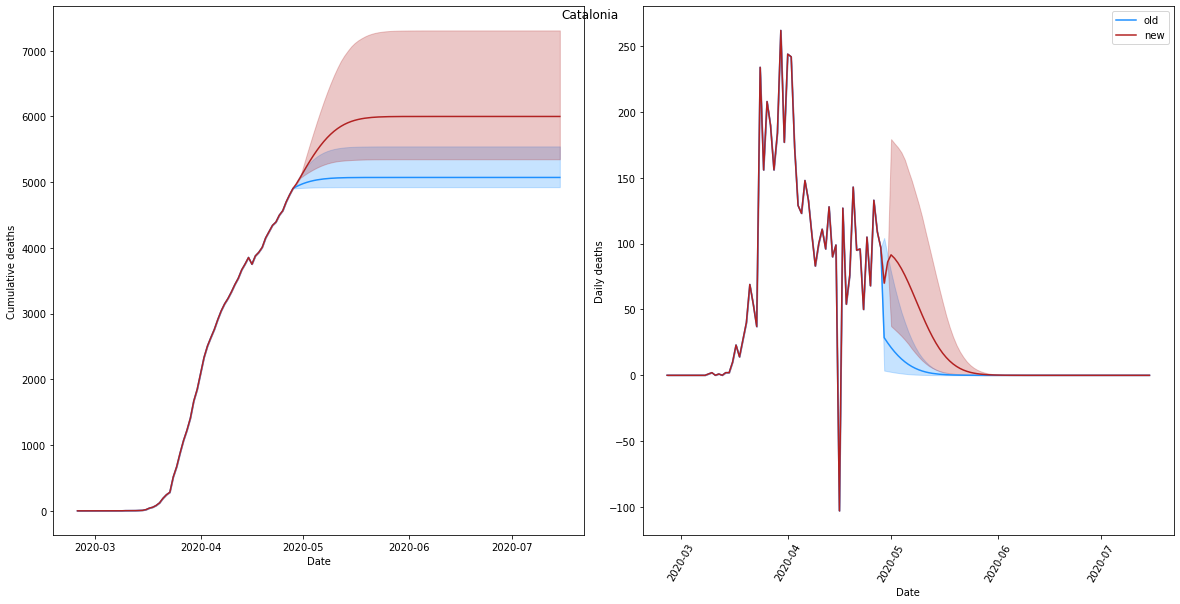

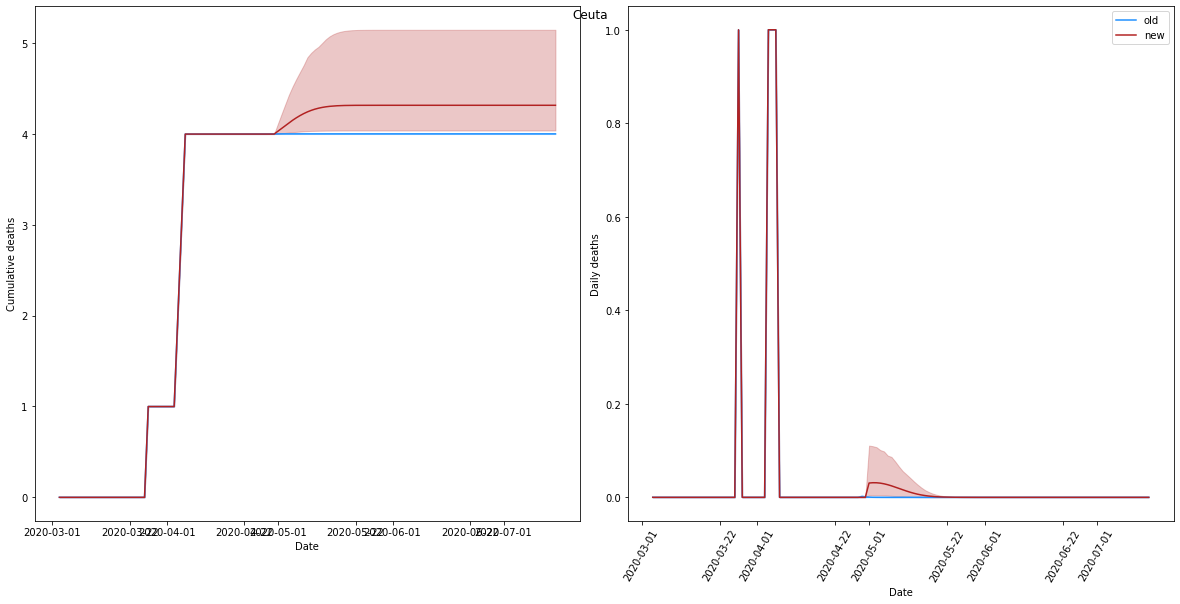

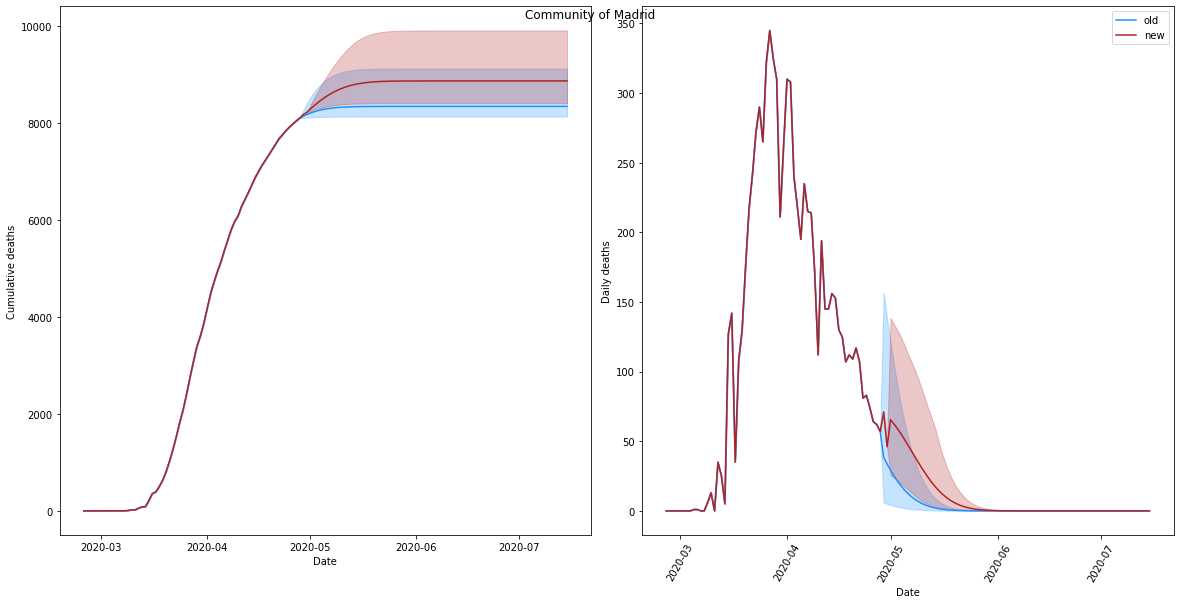

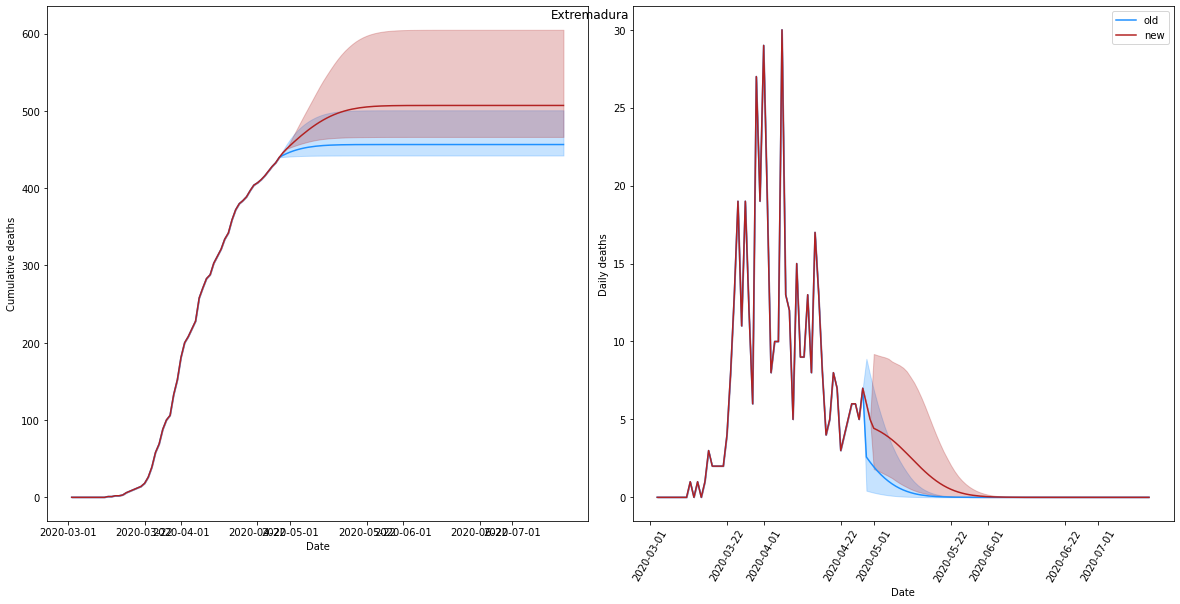

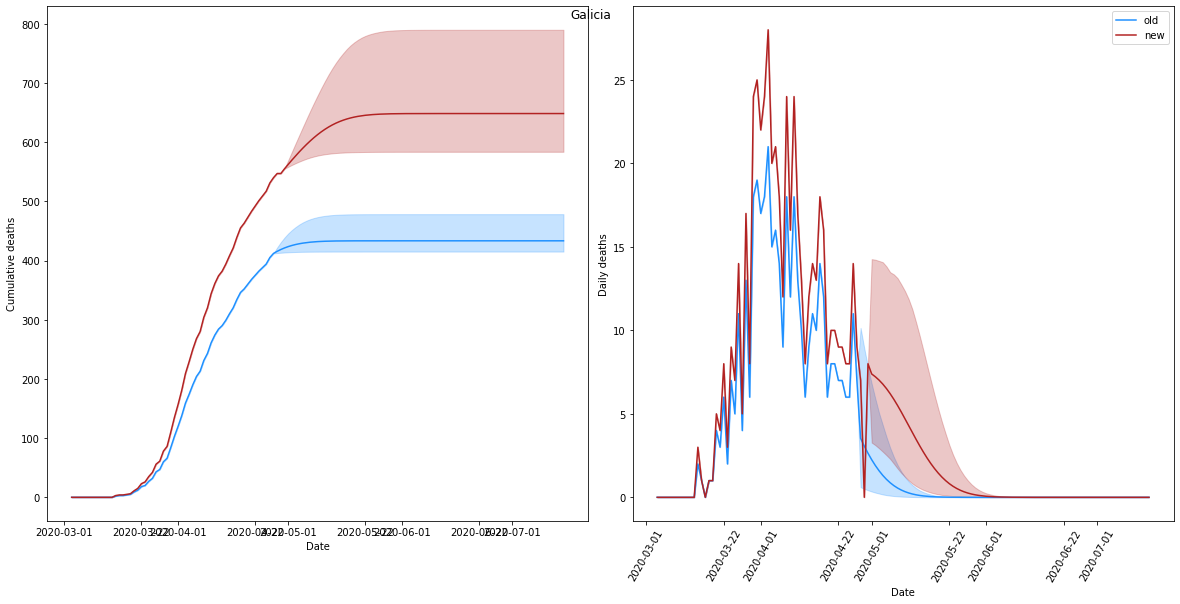

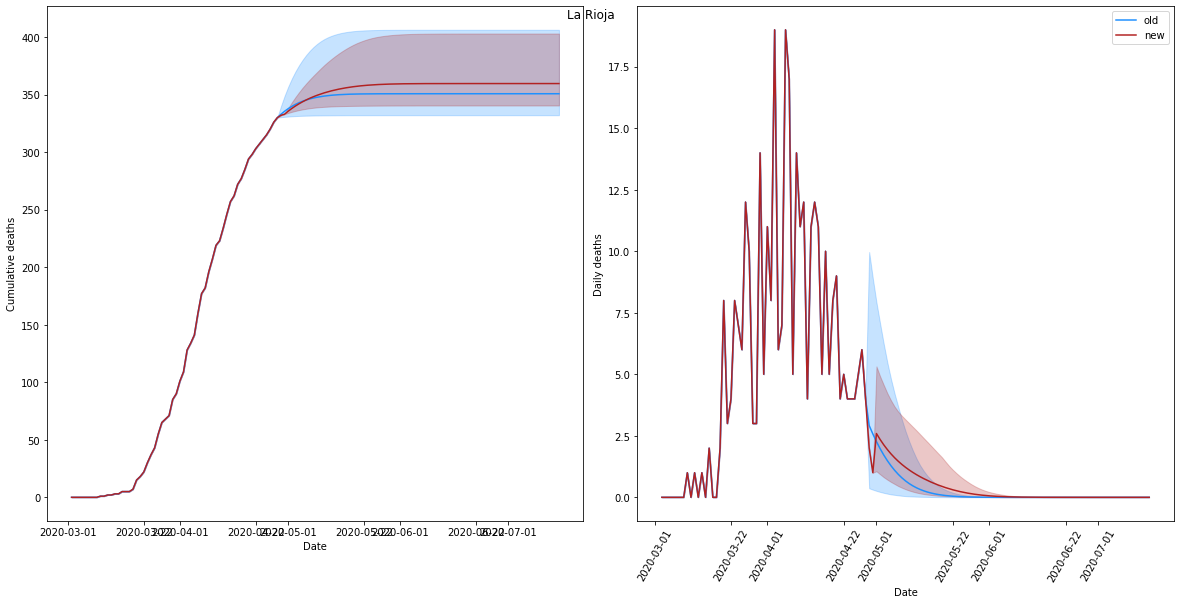

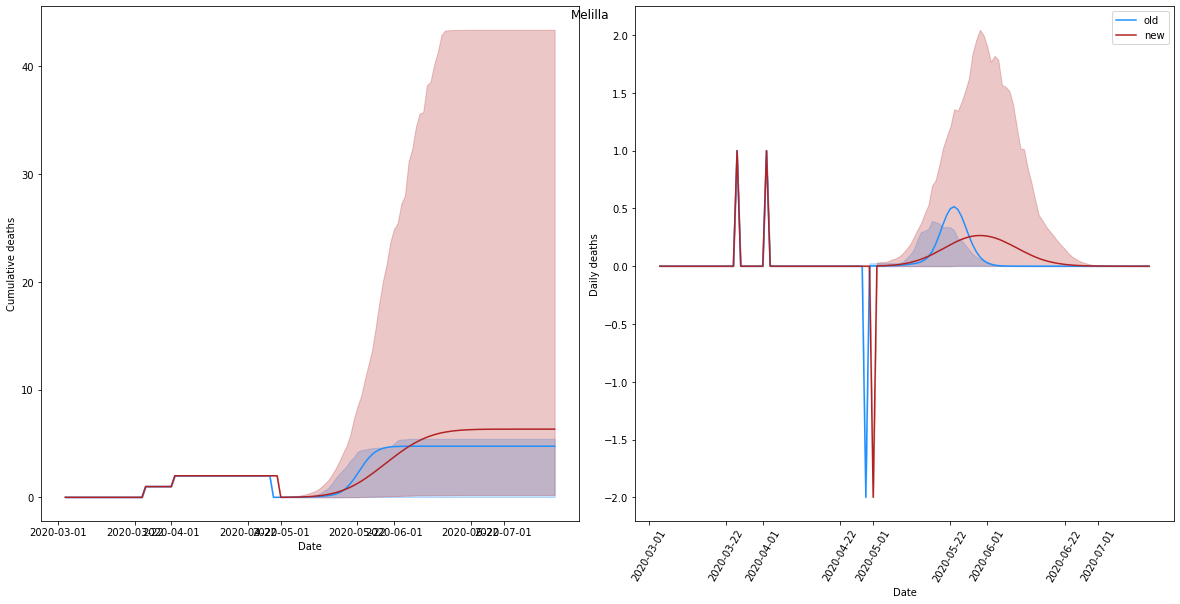

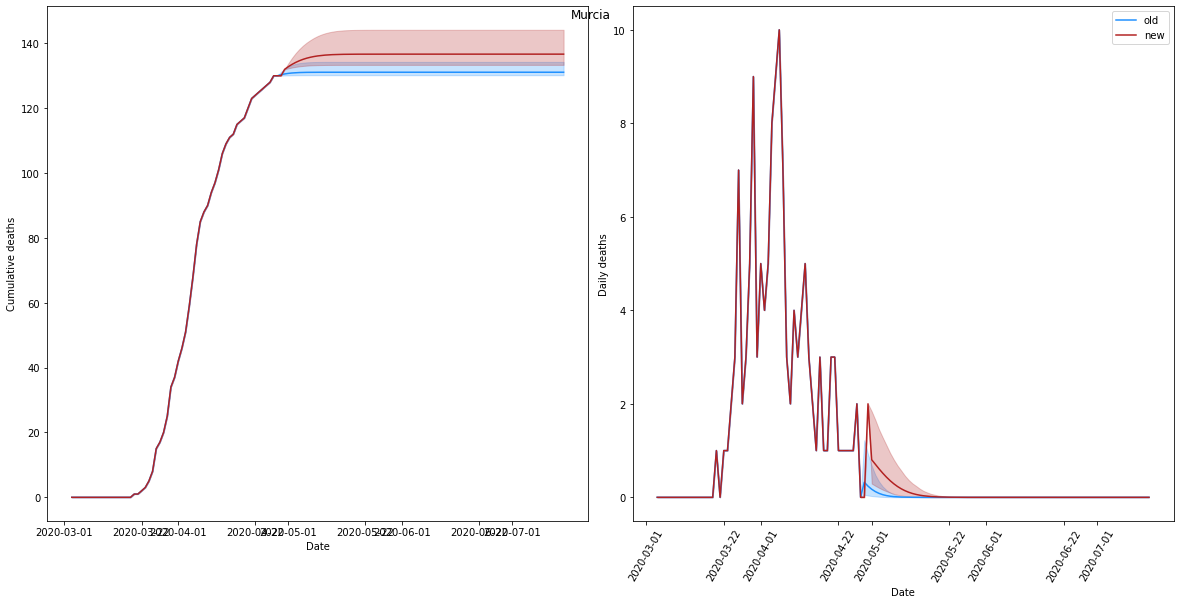

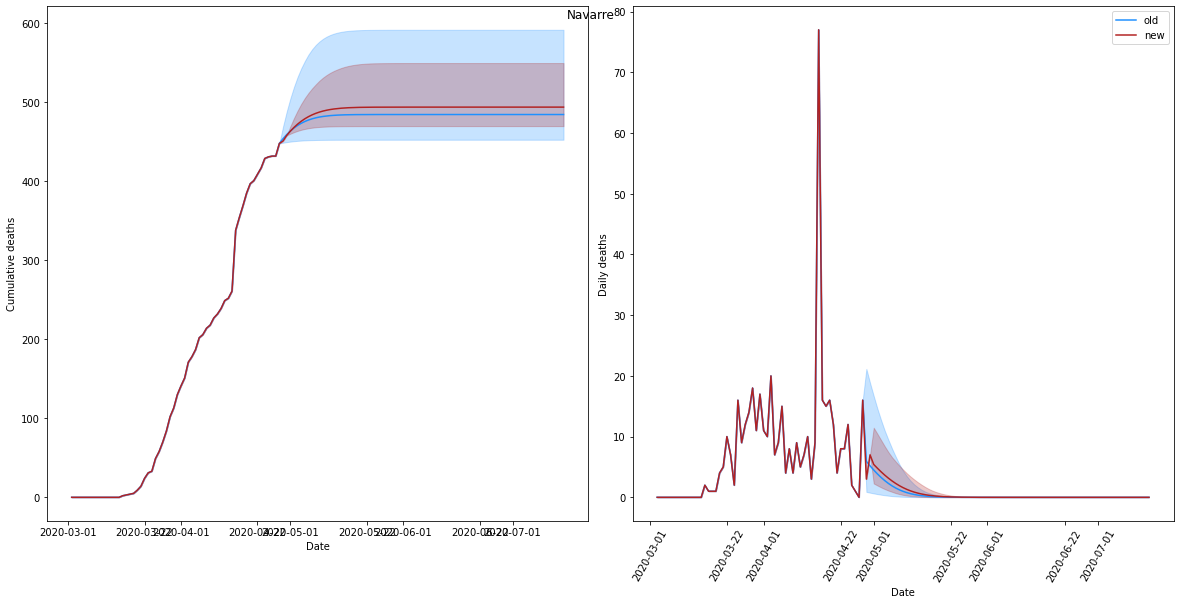

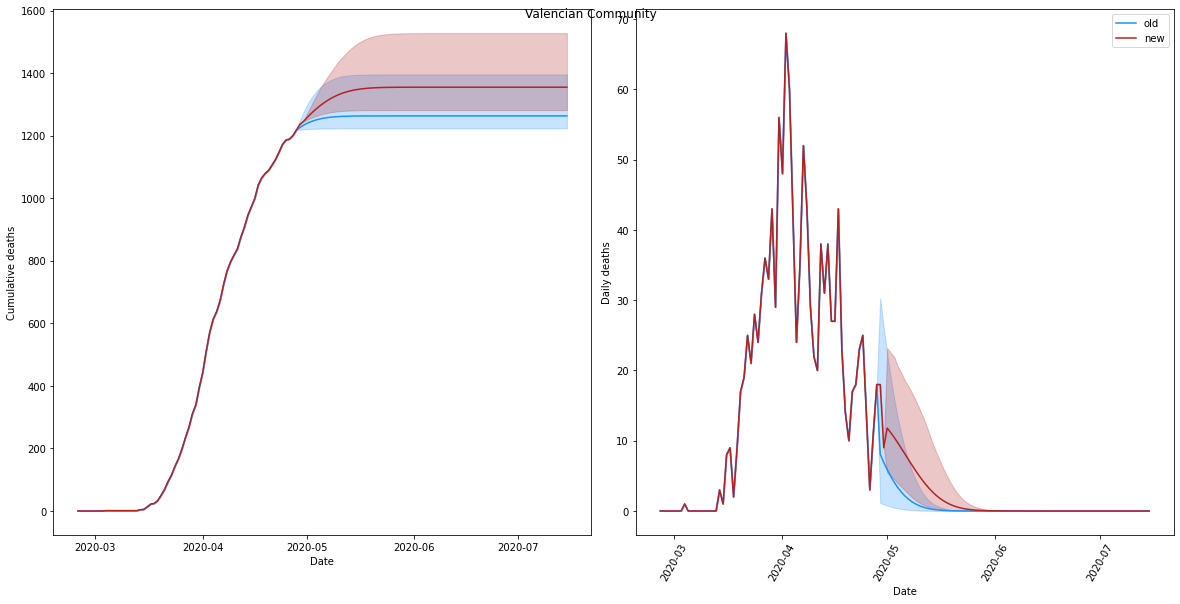

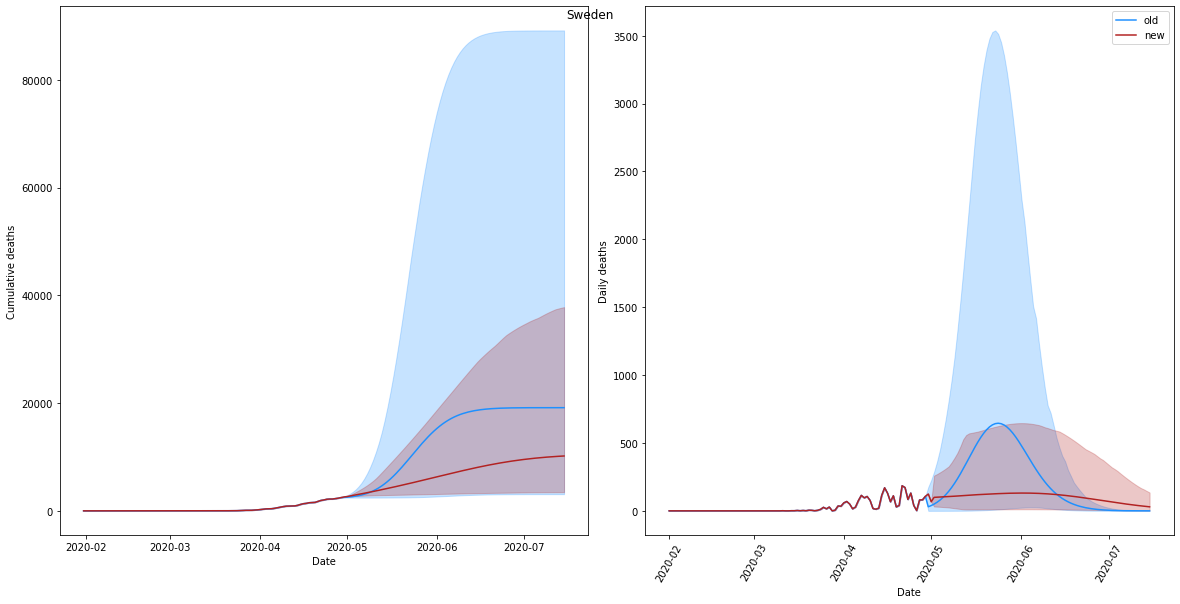

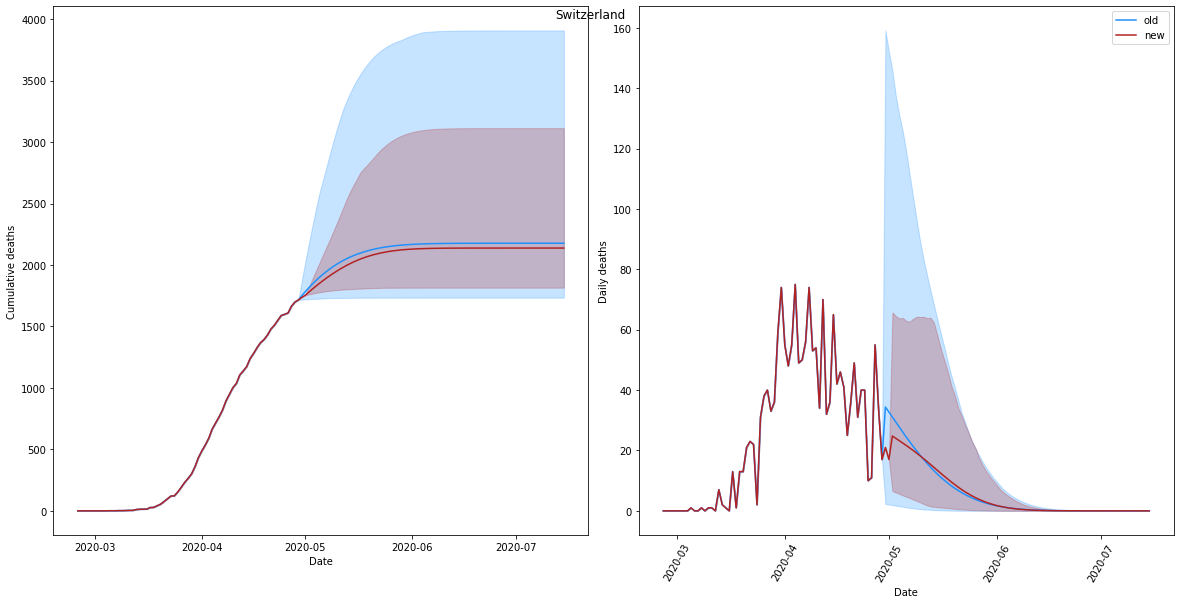

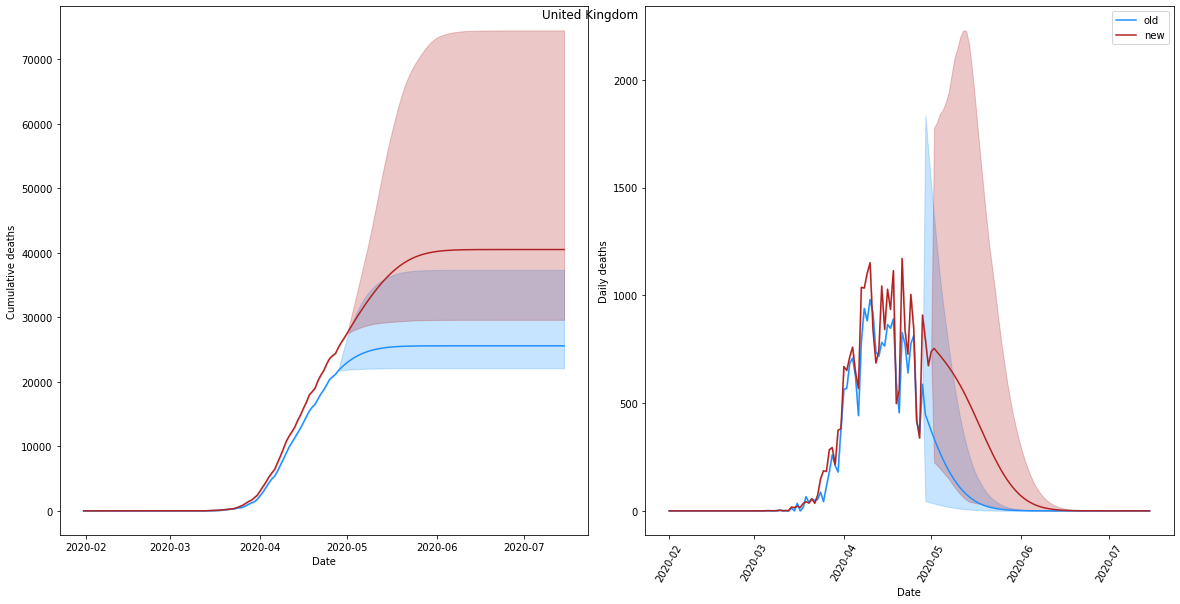

In [5]:
compare_to_previous_plot_path = runner.make_and_save_compare_to_previous_plots(OUTPUT_DIR,
                                                                               raw_draw_path,
                                                                               yesterday_draw_path,
                                                                               "Not US")

In [6]:
viz_dir = runner.send_plots_to_diagnostics(DATESTAMP_LABEL,
                                           f'{OUTPUT_DIR}/ensemble_plot.pdf',
                                           #compare_average_plot_path,
                                           compare_to_previous_plot_path)
print(viz_dir)

/home/j/Project/covid/results/diagnostics/deaths/2020_05_01_Europe_newmod


## store deaths with smoothed past

In [ ]:
runner.smooth_data(OUTPUT_DIR, raw_draw_path)

## store point estimates, and peaks derived from them

In [ ]:
loc_df = checkpoint.load('location')
submodel_dict = checkpoint.load('submodel_dict')
draw_df = checkpoint.load('draw_data')
age_pop_df = checkpoint.load('age_pop')

runner.save_points_and_peaks(loc_df, submodel_dict, draw_df, age_pop_df, OUTPUT_DIR)